In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from sklearn import preprocessing

from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications import inception_v3
from
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from keras import optimizers
from sklearn.linear_model import LogisticRegression
import h5py

Using TensorFlow backend.


In [2]:
traindf=pd.read_csv('../dogBreed/labels.csv')
testdf=pd.read_csv('../dogBreed/sample_submission.csv')

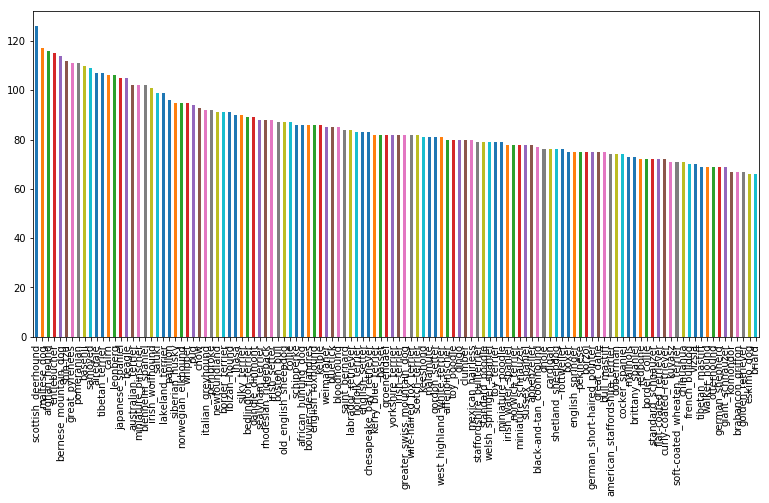

In [3]:
plt.figure(figsize=(13, 6))
traindf['breed'].value_counts().plot(kind='bar')
plt.show()

In [4]:
def class_percentages(labels):
    class_map={}
    for i in labels:
        if str(i) not in class_map:
            class_map[str(i)]=1
        else:
            class_map[str(i)]+=1
    #     print(class_map)
    return class_map

p=class_percentages(traindf.breed.values)
# print(p)
# for i in p.items():
#     print(i)

print("Class with maximum images-"+str(max(p, key=p.get))+"  "+str(p[max(p, key=p.get)]))
print("Class with maximum images-"+str(min(p,key=p.get)) +"  "+str(p[min(p, key=p.get)]))

Class with maximum images-scottish_deerhound  126
Class with maximum images-eskimo_dog  66


In [7]:
from keras.applications.inception_v3 import InceptionV3
num_classes = 120
inception_weights_path = "../../Keras-Pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

model = Sequential()
model.add(InceptionV3(include_top=False, pooling='avg', weights=inception_weights_path))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (InceptionNet) model. It is already trained
model.layers[0].trainable = False
model.summary()

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
activation_95 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 22,913,432
Trainable params: 1,110,648
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
from keras.applications.inception_v3 import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

image_size = 224
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                             rescale=1./255.,
                             horizontal_flip=True,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             validation_split=0.2)

In [10]:
train_generator=datagen.flow_from_dataframe(
                        dataframe=traindf,
                        directory="../dogBreed/train/",
                        x_col="id",
                        y_col="breed",
                        has_ext=False,
                        subset="training",
                        batch_size=32,
                        seed=50,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(image_size, image_size))

Found 8178 validated image filenames belonging to 120 classes.


In [11]:
valid_generator=datagen.flow_from_dataframe(
                        dataframe=traindf,
                        directory="../dogBreed/train/",
                        x_col="id",
                        y_col="breed",
                        has_ext=False,
                        subset="validation",
                        batch_size=1,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(image_size, image_size))

Found 2044 validated image filenames belonging to 120 classes.


In [12]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
                            dataframe=testdf,
                            directory="../dogBreed/test/",
                            x_col="id",
                            y_col=None,
                            has_ext=False,
                            batch_size=1,
                            seed=42,
                            shuffle=False,
                            class_mode=None,
                            target_size=(image_size, image_size))

Found 10357 validated image filenames.


In [14]:
STEP_SIZE_TRAIN=train_generator.n
STEP_SIZE_VALID=valid_generator.n

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=3
)

8178
2044
Epoch 1/3


 194/8178 [..............................] - ETA: 14:18:35 - loss: 4.8206 - acc: 0.031 - ETA: 7:31:33 - loss: 4.9971 - acc: 0.015 - ETA: 5:15:18 - loss: 5.0133 - acc: 0.01 - ETA: 4:07:31 - loss: 4.9883 - acc: 0.00 - ETA: 3:26:22 - loss: 4.9675 - acc: 0.01 - ETA: 2:58:59 - loss: 4.9794 - acc: 0.01 - ETA: 2:39:40 - loss: 4.9741 - acc: 0.00 - ETA: 2:25:06 - loss: 4.9859 - acc: 0.00 - ETA: 2:13:43 - loss: 4.9879 - acc: 0.00 - ETA: 2:04:41 - loss: 4.9710 - acc: 0.00 - ETA: 1:57:12 - loss: 4.9840 - acc: 0.00 - ETA: 1:50:56 - loss: 4.9694 - acc: 0.00 - ETA: 1:45:45 - loss: 4.9664 - acc: 0.00 - ETA: 1:41:16 - loss: 4.9624 - acc: 0.00 - ETA: 1:37:21 - loss: 4.9656 - acc: 0.00 - ETA: 1:34:00 - loss: 4.9535 - acc: 0.00 - ETA: 1:31:00 - loss: 4.9537 - acc: 0.00 - ETA: 1:28:21 - loss: 4.9442 - acc: 0.00 - ETA: 1:27:22 - loss: 4.9394 - acc: 0.00 - ETA: 1:26:51 - loss: 4.9383 - acc: 0.00 - ETA: 1:26:57 - loss: 4.9359 - acc: 0.00 - ETA: 1:26:33 - loss: 4.9312 - acc: 0.00 - ETA: 1:26:15 - loss: 4.9381 

 389/8178 [>.............................] - ETA: 1:21:01 - loss: 4.7401 - acc: 0.02 - ETA: 1:21:02 - loss: 4.7380 - acc: 0.02 - ETA: 1:21:01 - loss: 4.7369 - acc: 0.02 - ETA: 1:20:59 - loss: 4.7360 - acc: 0.02 - ETA: 1:21:01 - loss: 4.7346 - acc: 0.02 - ETA: 1:20:58 - loss: 4.7345 - acc: 0.02 - ETA: 1:20:56 - loss: 4.7340 - acc: 0.02 - ETA: 1:20:54 - loss: 4.7336 - acc: 0.03 - ETA: 1:20:51 - loss: 4.7326 - acc: 0.03 - ETA: 1:20:50 - loss: 4.7314 - acc: 0.03 - ETA: 1:20:49 - loss: 4.7301 - acc: 0.03 - ETA: 1:20:47 - loss: 4.7287 - acc: 0.03 - ETA: 1:20:45 - loss: 4.7277 - acc: 0.03 - ETA: 1:20:43 - loss: 4.7271 - acc: 0.03 - ETA: 1:20:42 - loss: 4.7262 - acc: 0.03 - ETA: 1:20:42 - loss: 4.7247 - acc: 0.03 - ETA: 1:20:39 - loss: 4.7244 - acc: 0.03 - ETA: 1:20:37 - loss: 4.7227 - acc: 0.03 - ETA: 1:20:34 - loss: 4.7220 - acc: 0.03 - ETA: 1:20:33 - loss: 4.7210 - acc: 0.03 - ETA: 1:20:31 - loss: 4.7210 - acc: 0.03 - ETA: 1:20:30 - loss: 4.7196 - acc: 0.03 - ETA: 1:20:30 - loss: 4.7185 - a

 584/8178 [=>............................] - ETA: 1:21:25 - loss: 4.5652 - acc: 0.06 - ETA: 1:21:29 - loss: 4.5640 - acc: 0.06 - ETA: 1:21:30 - loss: 4.5628 - acc: 0.06 - ETA: 1:21:32 - loss: 4.5617 - acc: 0.06 - ETA: 1:21:33 - loss: 4.5607 - acc: 0.06 - ETA: 1:21:35 - loss: 4.5596 - acc: 0.07 - ETA: 1:21:36 - loss: 4.5590 - acc: 0.07 - ETA: 1:21:37 - loss: 4.5577 - acc: 0.07 - ETA: 1:21:38 - loss: 4.5570 - acc: 0.07 - ETA: 1:21:38 - loss: 4.5556 - acc: 0.07 - ETA: 1:21:37 - loss: 4.5550 - acc: 0.07 - ETA: 1:21:38 - loss: 4.5536 - acc: 0.07 - ETA: 1:21:38 - loss: 4.5527 - acc: 0.07 - ETA: 1:21:39 - loss: 4.5516 - acc: 0.07 - ETA: 1:21:39 - loss: 4.5507 - acc: 0.07 - ETA: 1:21:40 - loss: 4.5496 - acc: 0.07 - ETA: 1:21:40 - loss: 4.5491 - acc: 0.07 - ETA: 1:21:40 - loss: 4.5484 - acc: 0.07 - ETA: 1:21:39 - loss: 4.5468 - acc: 0.07 - ETA: 1:21:38 - loss: 4.5458 - acc: 0.07 - ETA: 1:21:38 - loss: 4.5450 - acc: 0.07 - ETA: 1:22:06 - loss: 4.5440 - acc: 0.07 - ETA: 1:22:01 - loss: 4.5428 - a

 779/8178 [=>............................] - ETA: 1:23:43 - loss: 4.3680 - acc: 0.11 - ETA: 1:23:42 - loss: 4.3673 - acc: 0.11 - ETA: 1:23:41 - loss: 4.3659 - acc: 0.11 - ETA: 1:23:41 - loss: 4.3651 - acc: 0.11 - ETA: 1:23:40 - loss: 4.3645 - acc: 0.11 - ETA: 1:23:40 - loss: 4.3635 - acc: 0.11 - ETA: 1:23:35 - loss: 4.3636 - acc: 0.11 - ETA: 1:23:35 - loss: 4.3628 - acc: 0.11 - ETA: 1:23:34 - loss: 4.3614 - acc: 0.11 - ETA: 1:23:33 - loss: 4.3603 - acc: 0.11 - ETA: 1:23:32 - loss: 4.3594 - acc: 0.11 - ETA: 1:23:31 - loss: 4.3584 - acc: 0.11 - ETA: 1:23:30 - loss: 4.3570 - acc: 0.11 - ETA: 1:23:30 - loss: 4.3561 - acc: 0.11 - ETA: 1:23:29 - loss: 4.3547 - acc: 0.11 - ETA: 1:23:28 - loss: 4.3534 - acc: 0.11 - ETA: 1:23:28 - loss: 4.3523 - acc: 0.11 - ETA: 1:23:27 - loss: 4.3512 - acc: 0.11 - ETA: 1:23:26 - loss: 4.3504 - acc: 0.11 - ETA: 1:23:25 - loss: 4.3500 - acc: 0.11 - ETA: 1:23:24 - loss: 4.3487 - acc: 0.11 - ETA: 1:23:23 - loss: 4.3477 - acc: 0.11 - ETA: 1:23:22 - loss: 4.3470 - a

 974/8178 [==>...........................] - ETA: 1:22:39 - loss: 4.1747 - acc: 0.14 - ETA: 1:22:37 - loss: 4.1735 - acc: 0.14 - ETA: 1:22:36 - loss: 4.1724 - acc: 0.14 - ETA: 1:22:34 - loss: 4.1716 - acc: 0.14 - ETA: 1:22:32 - loss: 4.1707 - acc: 0.14 - ETA: 1:22:31 - loss: 4.1700 - acc: 0.14 - ETA: 1:22:29 - loss: 4.1691 - acc: 0.14 - ETA: 1:22:28 - loss: 4.1679 - acc: 0.14 - ETA: 1:22:26 - loss: 4.1671 - acc: 0.14 - ETA: 1:22:25 - loss: 4.1663 - acc: 0.14 - ETA: 1:22:23 - loss: 4.1652 - acc: 0.15 - ETA: 1:22:21 - loss: 4.1645 - acc: 0.15 - ETA: 1:22:20 - loss: 4.1634 - acc: 0.15 - ETA: 1:22:18 - loss: 4.1625 - acc: 0.15 - ETA: 1:22:17 - loss: 4.1615 - acc: 0.15 - ETA: 1:22:16 - loss: 4.1607 - acc: 0.15 - ETA: 1:22:15 - loss: 4.1600 - acc: 0.15 - ETA: 1:22:15 - loss: 4.1588 - acc: 0.15 - ETA: 1:22:14 - loss: 4.1576 - acc: 0.15 - ETA: 1:22:28 - loss: 4.1572 - acc: 0.15 - ETA: 1:22:24 - loss: 4.1560 - acc: 0.15 - ETA: 1:22:20 - loss: 4.1551 - acc: 0.15 - ETA: 1:22:17 - loss: 4.1541 - a

1169/8178 [===>..........................] - ETA: 1:21:34 - loss: 3.9858 - acc: 0.18 - ETA: 1:21:31 - loss: 3.9845 - acc: 0.18 - ETA: 1:21:41 - loss: 3.9833 - acc: 0.18 - ETA: 1:21:38 - loss: 3.9827 - acc: 0.18 - ETA: 1:21:35 - loss: 3.9814 - acc: 0.18 - ETA: 1:21:34 - loss: 3.9801 - acc: 0.18 - ETA: 1:21:44 - loss: 3.9795 - acc: 0.18 - ETA: 1:21:41 - loss: 3.9786 - acc: 0.18 - ETA: 1:21:50 - loss: 3.9781 - acc: 0.18 - ETA: 1:21:47 - loss: 3.9772 - acc: 0.18 - ETA: 1:21:44 - loss: 3.9764 - acc: 0.18 - ETA: 1:21:45 - loss: 3.9759 - acc: 0.18 - ETA: 1:21:56 - loss: 3.9747 - acc: 0.18 - ETA: 1:21:53 - loss: 3.9738 - acc: 0.18 - ETA: 1:21:50 - loss: 3.9729 - acc: 0.18 - ETA: 1:21:50 - loss: 3.9718 - acc: 0.18 - ETA: 1:22:01 - loss: 3.9705 - acc: 0.18 - ETA: 1:21:58 - loss: 3.9692 - acc: 0.18 - ETA: 1:22:05 - loss: 3.9683 - acc: 0.18 - ETA: 1:22:09 - loss: 3.9675 - acc: 0.18 - ETA: 1:22:06 - loss: 3.9667 - acc: 0.18 - ETA: 1:22:16 - loss: 3.9658 - acc: 0.18 - ETA: 1:22:13 - loss: 3.9650 - a

1364/8178 [====>.........................] - ETA: 1:22:00 - loss: 3.8121 - acc: 0.21 - ETA: 1:21:57 - loss: 3.8109 - acc: 0.21 - ETA: 1:22:03 - loss: 3.8097 - acc: 0.21 - ETA: 1:22:00 - loss: 3.8091 - acc: 0.21 - ETA: 1:21:57 - loss: 3.8085 - acc: 0.21 - ETA: 1:22:04 - loss: 3.8076 - acc: 0.21 - ETA: 1:22:02 - loss: 3.8066 - acc: 0.21 - ETA: 1:21:59 - loss: 3.8056 - acc: 0.21 - ETA: 1:21:56 - loss: 3.8049 - acc: 0.21 - ETA: 1:21:54 - loss: 3.8040 - acc: 0.21 - ETA: 1:21:54 - loss: 3.8029 - acc: 0.21 - ETA: 1:21:53 - loss: 3.8019 - acc: 0.21 - ETA: 1:22:00 - loss: 3.8010 - acc: 0.21 - ETA: 1:21:58 - loss: 3.8003 - acc: 0.21 - ETA: 1:21:55 - loss: 3.7991 - acc: 0.21 - ETA: 1:22:02 - loss: 3.7983 - acc: 0.21 - ETA: 1:22:00 - loss: 3.7973 - acc: 0.21 - ETA: 1:21:57 - loss: 3.7967 - acc: 0.21 - ETA: 1:21:55 - loss: 3.7955 - acc: 0.21 - ETA: 1:21:55 - loss: 3.7942 - acc: 0.21 - ETA: 1:21:54 - loss: 3.7931 - acc: 0.21 - ETA: 1:21:53 - loss: 3.7921 - acc: 0.21 - ETA: 1:22:02 - loss: 3.7913 - a

1559/8178 [====>.........................] - ETA: 1:19:28 - loss: 3.6536 - acc: 0.23 - ETA: 1:19:27 - loss: 3.6529 - acc: 0.23 - ETA: 1:19:26 - loss: 3.6522 - acc: 0.23 - ETA: 1:19:24 - loss: 3.6514 - acc: 0.23 - ETA: 1:19:23 - loss: 3.6509 - acc: 0.23 - ETA: 1:19:28 - loss: 3.6502 - acc: 0.23 - ETA: 1:19:26 - loss: 3.6491 - acc: 0.23 - ETA: 1:19:23 - loss: 3.6482 - acc: 0.23 - ETA: 1:19:21 - loss: 3.6471 - acc: 0.23 - ETA: 1:19:20 - loss: 3.6466 - acc: 0.23 - ETA: 1:19:19 - loss: 3.6458 - acc: 0.23 - ETA: 1:19:18 - loss: 3.6455 - acc: 0.23 - ETA: 1:19:16 - loss: 3.6450 - acc: 0.23 - ETA: 1:19:15 - loss: 3.6443 - acc: 0.23 - ETA: 1:19:14 - loss: 3.6434 - acc: 0.23 - ETA: 1:19:12 - loss: 3.6428 - acc: 0.23 - ETA: 1:19:11 - loss: 3.6419 - acc: 0.23 - ETA: 1:19:10 - loss: 3.6413 - acc: 0.23 - ETA: 1:19:08 - loss: 3.6405 - acc: 0.23 - ETA: 1:19:07 - loss: 3.6396 - acc: 0.23 - ETA: 1:19:06 - loss: 3.6387 - acc: 0.23 - ETA: 1:19:04 - loss: 3.6382 - acc: 0.23 - ETA: 1:19:03 - loss: 3.6377 - a

1754/8178 [=====>........................] - ETA: 1:16:15 - loss: 3.5155 - acc: 0.25 - ETA: 1:16:14 - loss: 3.5151 - acc: 0.25 - ETA: 1:16:12 - loss: 3.5144 - acc: 0.25 - ETA: 1:16:11 - loss: 3.5139 - acc: 0.25 - ETA: 1:16:15 - loss: 3.5131 - acc: 0.25 - ETA: 1:16:13 - loss: 3.5122 - acc: 0.25 - ETA: 1:16:10 - loss: 3.5114 - acc: 0.25 - ETA: 1:16:13 - loss: 3.5108 - acc: 0.25 - ETA: 1:16:11 - loss: 3.5101 - acc: 0.26 - ETA: 1:16:14 - loss: 3.5093 - acc: 0.26 - ETA: 1:16:12 - loss: 3.5088 - acc: 0.26 - ETA: 1:16:10 - loss: 3.5084 - acc: 0.26 - ETA: 1:16:09 - loss: 3.5079 - acc: 0.26 - ETA: 1:16:07 - loss: 3.5074 - acc: 0.26 - ETA: 1:16:06 - loss: 3.5066 - acc: 0.26 - ETA: 1:16:05 - loss: 3.5062 - acc: 0.26 - ETA: 1:16:04 - loss: 3.5052 - acc: 0.26 - ETA: 1:16:02 - loss: 3.5045 - acc: 0.26 - ETA: 1:16:01 - loss: 3.5039 - acc: 0.26 - ETA: 1:16:00 - loss: 3.5033 - acc: 0.26 - ETA: 1:15:59 - loss: 3.5029 - acc: 0.26 - ETA: 1:15:57 - loss: 3.5021 - acc: 0.26 - ETA: 1:16:01 - loss: 3.5014 - a

1949/8178 [======>.......................] - ETA: 1:13:45 - loss: 3.3902 - acc: 0.27 - ETA: 1:13:44 - loss: 3.3897 - acc: 0.27 - ETA: 1:13:43 - loss: 3.3889 - acc: 0.27 - ETA: 1:13:42 - loss: 3.3883 - acc: 0.27 - ETA: 1:13:41 - loss: 3.3880 - acc: 0.28 - ETA: 1:13:40 - loss: 3.3874 - acc: 0.28 - ETA: 1:13:39 - loss: 3.3867 - acc: 0.28 - ETA: 1:13:38 - loss: 3.3860 - acc: 0.28 - ETA: 1:13:36 - loss: 3.3854 - acc: 0.28 - ETA: 1:13:35 - loss: 3.3847 - acc: 0.28 - ETA: 1:13:34 - loss: 3.3845 - acc: 0.28 - ETA: 1:13:33 - loss: 3.3836 - acc: 0.28 - ETA: 1:13:36 - loss: 3.3830 - acc: 0.28 - ETA: 1:13:35 - loss: 3.3824 - acc: 0.28 - ETA: 1:13:32 - loss: 3.3817 - acc: 0.28 - ETA: 1:13:30 - loss: 3.3811 - acc: 0.28 - ETA: 1:13:29 - loss: 3.3806 - acc: 0.28 - ETA: 1:13:28 - loss: 3.3801 - acc: 0.28 - ETA: 1:13:27 - loss: 3.3795 - acc: 0.28 - ETA: 1:13:30 - loss: 3.3789 - acc: 0.28 - ETA: 1:13:28 - loss: 3.3784 - acc: 0.28 - ETA: 1:13:26 - loss: 3.3777 - acc: 0.28 - ETA: 1:13:24 - loss: 3.3770 - a

2144/8178 [======>.......................] - ETA: 1:11:40 - loss: 3.2825 - acc: 0.29 - ETA: 1:11:39 - loss: 3.2822 - acc: 0.29 - ETA: 1:11:38 - loss: 3.2817 - acc: 0.29 - ETA: 1:11:37 - loss: 3.2812 - acc: 0.29 - ETA: 1:11:35 - loss: 3.2807 - acc: 0.29 - ETA: 1:11:38 - loss: 3.2803 - acc: 0.29 - ETA: 1:11:36 - loss: 3.2798 - acc: 0.29 - ETA: 1:11:34 - loss: 3.2793 - acc: 0.29 - ETA: 1:11:37 - loss: 3.2787 - acc: 0.29 - ETA: 1:11:35 - loss: 3.2782 - acc: 0.29 - ETA: 1:11:33 - loss: 3.2776 - acc: 0.29 - ETA: 1:11:36 - loss: 3.2770 - acc: 0.29 - ETA: 1:11:35 - loss: 3.2763 - acc: 0.29 - ETA: 1:11:33 - loss: 3.2758 - acc: 0.29 - ETA: 1:11:32 - loss: 3.2753 - acc: 0.29 - ETA: 1:11:35 - loss: 3.2750 - acc: 0.29 - ETA: 1:11:33 - loss: 3.2745 - acc: 0.29 - ETA: 1:11:31 - loss: 3.2740 - acc: 0.29 - ETA: 1:11:33 - loss: 3.2735 - acc: 0.29 - ETA: 1:11:32 - loss: 3.2731 - acc: 0.29 - ETA: 1:11:30 - loss: 3.2727 - acc: 0.29 - ETA: 1:11:33 - loss: 3.2722 - acc: 0.29 - ETA: 1:11:31 - loss: 3.2715 - a

2339/8178 [=======>......................] - ETA: 1:10:39 - loss: 3.1832 - acc: 0.31 - ETA: 1:10:37 - loss: 3.1827 - acc: 0.31 - ETA: 1:10:41 - loss: 3.1821 - acc: 0.31 - ETA: 1:10:40 - loss: 3.1816 - acc: 0.31 - ETA: 1:10:38 - loss: 3.1812 - acc: 0.31 - ETA: 1:10:39 - loss: 3.1808 - acc: 0.31 - ETA: 1:10:38 - loss: 3.1803 - acc: 0.31 - ETA: 1:10:40 - loss: 3.1798 - acc: 0.31 - ETA: 1:10:38 - loss: 3.1793 - acc: 0.31 - ETA: 1:10:36 - loss: 3.1787 - acc: 0.31 - ETA: 1:10:39 - loss: 3.1779 - acc: 0.31 - ETA: 1:10:37 - loss: 3.1773 - acc: 0.31 - ETA: 1:10:35 - loss: 3.1770 - acc: 0.31 - ETA: 1:10:34 - loss: 3.1767 - acc: 0.31 - ETA: 1:10:36 - loss: 3.1762 - acc: 0.31 - ETA: 1:10:35 - loss: 3.1757 - acc: 0.31 - ETA: 1:10:33 - loss: 3.1751 - acc: 0.31 - ETA: 1:10:35 - loss: 3.1747 - acc: 0.31 - ETA: 1:10:33 - loss: 3.1741 - acc: 0.31 - ETA: 1:10:31 - loss: 3.1738 - acc: 0.31 - ETA: 1:10:34 - loss: 3.1733 - acc: 0.31 - ETA: 1:10:33 - loss: 3.1728 - acc: 0.31 - ETA: 1:10:31 - loss: 3.1722 - a

2534/8178 [========>.....................] - ETA: 1:09:11 - loss: 3.0980 - acc: 0.32 - ETA: 1:09:10 - loss: 3.0975 - acc: 0.32 - ETA: 1:09:12 - loss: 3.0971 - acc: 0.32 - ETA: 1:09:10 - loss: 3.0966 - acc: 0.32 - ETA: 1:09:12 - loss: 3.0962 - acc: 0.32 - ETA: 1:09:10 - loss: 3.0959 - acc: 0.32 - ETA: 1:09:08 - loss: 3.0954 - acc: 0.32 - ETA: 1:09:07 - loss: 3.0951 - acc: 0.32 - ETA: 1:09:08 - loss: 3.0946 - acc: 0.32 - ETA: 1:09:07 - loss: 3.0941 - acc: 0.32 - ETA: 1:09:08 - loss: 3.0936 - acc: 0.32 - ETA: 1:09:07 - loss: 3.0932 - acc: 0.32 - ETA: 1:09:05 - loss: 3.0930 - acc: 0.32 - ETA: 1:09:06 - loss: 3.0926 - acc: 0.32 - ETA: 1:09:05 - loss: 3.0921 - acc: 0.32 - ETA: 1:09:03 - loss: 3.0918 - acc: 0.32 - ETA: 1:09:05 - loss: 3.0913 - acc: 0.32 - ETA: 1:09:03 - loss: 3.0907 - acc: 0.32 - ETA: 1:09:05 - loss: 3.0901 - acc: 0.32 - ETA: 1:09:03 - loss: 3.0898 - acc: 0.32 - ETA: 1:09:04 - loss: 3.0894 - acc: 0.32 - ETA: 1:09:04 - loss: 3.0889 - acc: 0.32 - ETA: 1:09:05 - loss: 3.0885 - a

2729/8178 [=========>....................] - ETA: 1:07:38 - loss: 3.0202 - acc: 0.33 - ETA: 1:07:37 - loss: 3.0197 - acc: 0.33 - ETA: 1:07:36 - loss: 3.0192 - acc: 0.33 - ETA: 1:07:37 - loss: 3.0189 - acc: 0.33 - ETA: 1:07:36 - loss: 3.0185 - acc: 0.33 - ETA: 1:07:34 - loss: 3.0183 - acc: 0.33 - ETA: 1:07:36 - loss: 3.0180 - acc: 0.33 - ETA: 1:07:34 - loss: 3.0175 - acc: 0.33 - ETA: 1:07:33 - loss: 3.0171 - acc: 0.34 - ETA: 1:07:31 - loss: 3.0168 - acc: 0.34 - ETA: 1:07:32 - loss: 3.0164 - acc: 0.34 - ETA: 1:07:32 - loss: 3.0161 - acc: 0.34 - ETA: 1:07:34 - loss: 3.0157 - acc: 0.34 - ETA: 1:07:32 - loss: 3.0150 - acc: 0.34 - ETA: 1:07:31 - loss: 3.0147 - acc: 0.34 - ETA: 1:07:32 - loss: 3.0143 - acc: 0.34 - ETA: 1:07:30 - loss: 3.0140 - acc: 0.34 - ETA: 1:07:31 - loss: 3.0136 - acc: 0.34 - ETA: 1:07:29 - loss: 3.0133 - acc: 0.34 - ETA: 1:07:30 - loss: 3.0127 - acc: 0.34 - ETA: 1:07:29 - loss: 3.0123 - acc: 0.34 - ETA: 1:07:27 - loss: 3.0120 - acc: 0.34 - ETA: 1:07:28 - loss: 3.0116 - a

2924/8178 [=========>....................] - ETA: 1:05:56 - loss: 2.9491 - acc: 0.35 - ETA: 1:05:57 - loss: 2.9488 - acc: 0.35 - ETA: 1:05:56 - loss: 2.9483 - acc: 0.35 - ETA: 1:05:54 - loss: 2.9480 - acc: 0.35 - ETA: 1:05:55 - loss: 2.9476 - acc: 0.35 - ETA: 1:05:53 - loss: 2.9474 - acc: 0.35 - ETA: 1:05:54 - loss: 2.9471 - acc: 0.35 - ETA: 1:05:53 - loss: 2.9467 - acc: 0.35 - ETA: 1:05:51 - loss: 2.9465 - acc: 0.35 - ETA: 1:05:50 - loss: 2.9460 - acc: 0.35 - ETA: 1:05:49 - loss: 2.9456 - acc: 0.35 - ETA: 1:05:50 - loss: 2.9452 - acc: 0.35 - ETA: 1:05:49 - loss: 2.9447 - acc: 0.35 - ETA: 1:05:47 - loss: 2.9443 - acc: 0.35 - ETA: 1:05:48 - loss: 2.9439 - acc: 0.35 - ETA: 1:05:47 - loss: 2.9435 - acc: 0.35 - ETA: 1:05:46 - loss: 2.9432 - acc: 0.35 - ETA: 1:05:46 - loss: 2.9428 - acc: 0.35 - ETA: 1:05:47 - loss: 2.9426 - acc: 0.35 - ETA: 1:05:49 - loss: 2.9422 - acc: 0.35 - ETA: 1:05:47 - loss: 2.9419 - acc: 0.35 - ETA: 1:05:49 - loss: 2.9416 - acc: 0.35 - ETA: 1:05:49 - loss: 2.9414 - a

3119/8178 [==========>...................] - ETA: 1:04:25 - loss: 2.8838 - acc: 0.36 - ETA: 1:04:24 - loss: 2.8833 - acc: 0.36 - ETA: 1:04:22 - loss: 2.8830 - acc: 0.36 - ETA: 1:04:23 - loss: 2.8827 - acc: 0.36 - ETA: 1:04:24 - loss: 2.8823 - acc: 0.36 - ETA: 1:04:22 - loss: 2.8818 - acc: 0.36 - ETA: 1:04:21 - loss: 2.8814 - acc: 0.36 - ETA: 1:04:19 - loss: 2.8811 - acc: 0.36 - ETA: 1:04:18 - loss: 2.8808 - acc: 0.36 - ETA: 1:04:19 - loss: 2.8804 - acc: 0.36 - ETA: 1:04:18 - loss: 2.8801 - acc: 0.36 - ETA: 1:04:16 - loss: 2.8798 - acc: 0.36 - ETA: 1:04:17 - loss: 2.8793 - acc: 0.36 - ETA: 1:04:18 - loss: 2.8791 - acc: 0.36 - ETA: 1:04:17 - loss: 2.8787 - acc: 0.36 - ETA: 1:04:16 - loss: 2.8783 - acc: 0.36 - ETA: 1:04:15 - loss: 2.8780 - acc: 0.36 - ETA: 1:04:16 - loss: 2.8776 - acc: 0.36 - ETA: 1:04:15 - loss: 2.8772 - acc: 0.36 - ETA: 1:04:14 - loss: 2.8768 - acc: 0.36 - ETA: 1:04:12 - loss: 2.8766 - acc: 0.36 - ETA: 1:04:11 - loss: 2.8764 - acc: 0.36 - ETA: 1:04:12 - loss: 2.8762 - a

3314/8178 [===========>..................] - ETA: 1:02:43 - loss: 2.8265 - acc: 0.37 - ETA: 1:02:41 - loss: 2.8261 - acc: 0.37 - ETA: 1:02:42 - loss: 2.8259 - acc: 0.37 - ETA: 1:02:40 - loss: 2.8256 - acc: 0.37 - ETA: 1:02:39 - loss: 2.8252 - acc: 0.37 - ETA: 1:02:40 - loss: 2.8249 - acc: 0.37 - ETA: 1:02:39 - loss: 2.8247 - acc: 0.37 - ETA: 1:02:37 - loss: 2.8242 - acc: 0.37 - ETA: 1:02:36 - loss: 2.8238 - acc: 0.37 - ETA: 1:02:36 - loss: 2.8236 - acc: 0.37 - ETA: 1:02:37 - loss: 2.8231 - acc: 0.37 - ETA: 1:02:36 - loss: 2.8228 - acc: 0.37 - ETA: 1:02:34 - loss: 2.8225 - acc: 0.37 - ETA: 1:02:33 - loss: 2.8223 - acc: 0.37 - ETA: 1:02:34 - loss: 2.8222 - acc: 0.37 - ETA: 1:02:32 - loss: 2.8219 - acc: 0.37 - ETA: 1:02:31 - loss: 2.8214 - acc: 0.37 - ETA: 1:02:32 - loss: 2.8212 - acc: 0.37 - ETA: 1:02:31 - loss: 2.8207 - acc: 0.37 - ETA: 1:02:29 - loss: 2.8204 - acc: 0.37 - ETA: 1:02:30 - loss: 2.8202 - acc: 0.37 - ETA: 1:02:29 - loss: 2.8200 - acc: 0.37 - ETA: 1:02:27 - loss: 2.8197 - a

3513/8178 [===========>..................] - ETA: 1:01:04 - loss: 2.7741 - acc: 0.37 - ETA: 1:01:04 - loss: 2.7737 - acc: 0.37 - ETA: 1:01:04 - loss: 2.7736 - acc: 0.37 - ETA: 1:01:03 - loss: 2.7733 - acc: 0.37 - ETA: 1:01:02 - loss: 2.7730 - acc: 0.37 - ETA: 1:01:02 - loss: 2.7727 - acc: 0.37 - ETA: 1:01:02 - loss: 2.7724 - acc: 0.37 - ETA: 1:01:02 - loss: 2.7720 - acc: 0.37 - ETA: 1:01:01 - loss: 2.7717 - acc: 0.37 - ETA: 1:01:02 - loss: 2.7716 - acc: 0.37 - ETA: 1:01:00 - loss: 2.7714 - acc: 0.37 - ETA: 1:00:59 - loss: 2.7711 - acc: 0.37 - ETA: 1:00:59 - loss: 2.7709 - acc: 0.37 - ETA: 1:00:58 - loss: 2.7706 - acc: 0.37 - ETA: 1:00:59 - loss: 2.7702 - acc: 0.37 - ETA: 1:00:57 - loss: 2.7698 - acc: 0.37 - ETA: 1:00:56 - loss: 2.7697 - acc: 0.37 - ETA: 1:00:56 - loss: 2.7695 - acc: 0.37 - ETA: 1:00:55 - loss: 2.7692 - acc: 0.37 - ETA: 1:00:53 - loss: 2.7688 - acc: 0.37 - ETA: 1:00:52 - loss: 2.7686 - acc: 0.37 - ETA: 1:00:51 - loss: 2.7684 - acc: 0.37 - ETA: 1:00:50 - loss: 2.7680 - a

3717/8178 [============>.................] - ETA: 59:13 - loss: 2.7240 - acc: 0.38 - ETA: 59:15 - loss: 2.7238 - acc: 0.38 - ETA: 59:14 - loss: 2.7235 - acc: 0.38 - ETA: 59:15 - loss: 2.7233 - acc: 0.38 - ETA: 59:14 - loss: 2.7231 - acc: 0.38 - ETA: 59:13 - loss: 2.7229 - acc: 0.38 - ETA: 59:13 - loss: 2.7227 - acc: 0.38 - ETA: 59:12 - loss: 2.7223 - acc: 0.38 - ETA: 59:11 - loss: 2.7221 - acc: 0.38 - ETA: 59:11 - loss: 2.7217 - acc: 0.38 - ETA: 59:10 - loss: 2.7214 - acc: 0.38 - ETA: 59:09 - loss: 2.7211 - acc: 0.38 - ETA: 59:09 - loss: 2.7209 - acc: 0.38 - ETA: 59:08 - loss: 2.7206 - acc: 0.38 - ETA: 59:06 - loss: 2.7203 - acc: 0.38 - ETA: 59:05 - loss: 2.7201 - acc: 0.38 - ETA: 59:04 - loss: 2.7199 - acc: 0.38 - ETA: 59:05 - loss: 2.7198 - acc: 0.38 - ETA: 59:03 - loss: 2.7196 - acc: 0.38 - ETA: 59:04 - loss: 2.7193 - acc: 0.38 - ETA: 59:03 - loss: 2.7190 - acc: 0.38 - ETA: 59:02 - loss: 2.7189 - acc: 0.38 - ETA: 59:02 - loss: 2.7186 - acc: 0.38 - ETA: 59:02 - loss: 2.7182 - acc: 0.

3921/8178 [=============>................] - ETA: 57:07 - loss: 2.6767 - acc: 0.39 - ETA: 57:06 - loss: 2.6765 - acc: 0.39 - ETA: 57:06 - loss: 2.6763 - acc: 0.39 - ETA: 57:05 - loss: 2.6761 - acc: 0.39 - ETA: 57:04 - loss: 2.6759 - acc: 0.39 - ETA: 57:04 - loss: 2.6757 - acc: 0.39 - ETA: 57:04 - loss: 2.6754 - acc: 0.39 - ETA: 57:02 - loss: 2.6753 - acc: 0.39 - ETA: 57:03 - loss: 2.6750 - acc: 0.39 - ETA: 57:01 - loss: 2.6748 - acc: 0.39 - ETA: 57:00 - loss: 2.6745 - acc: 0.39 - ETA: 57:00 - loss: 2.6743 - acc: 0.39 - ETA: 56:59 - loss: 2.6741 - acc: 0.39 - ETA: 56:58 - loss: 2.6739 - acc: 0.39 - ETA: 56:58 - loss: 2.6737 - acc: 0.39 - ETA: 56:57 - loss: 2.6735 - acc: 0.39 - ETA: 56:57 - loss: 2.6732 - acc: 0.39 - ETA: 56:57 - loss: 2.6730 - acc: 0.39 - ETA: 56:56 - loss: 2.6728 - acc: 0.39 - ETA: 56:57 - loss: 2.6725 - acc: 0.39 - ETA: 56:56 - loss: 2.6723 - acc: 0.39 - ETA: 56:55 - loss: 2.6721 - acc: 0.39 - ETA: 56:54 - loss: 2.6720 - acc: 0.39 - ETA: 56:55 - loss: 2.6717 - acc: 0.

4125/8178 [==============>...............] - ETA: 54:51 - loss: 2.6350 - acc: 0.40 - ETA: 54:51 - loss: 2.6349 - acc: 0.40 - ETA: 54:51 - loss: 2.6348 - acc: 0.40 - ETA: 54:50 - loss: 2.6347 - acc: 0.40 - ETA: 54:48 - loss: 2.6345 - acc: 0.40 - ETA: 54:48 - loss: 2.6343 - acc: 0.40 - ETA: 54:48 - loss: 2.6341 - acc: 0.40 - ETA: 54:48 - loss: 2.6339 - acc: 0.40 - ETA: 54:47 - loss: 2.6338 - acc: 0.40 - ETA: 54:46 - loss: 2.6335 - acc: 0.40 - ETA: 54:46 - loss: 2.6333 - acc: 0.40 - ETA: 54:44 - loss: 2.6332 - acc: 0.40 - ETA: 54:44 - loss: 2.6331 - acc: 0.40 - ETA: 54:43 - loss: 2.6329 - acc: 0.40 - ETA: 54:42 - loss: 2.6326 - acc: 0.40 - ETA: 54:42 - loss: 2.6323 - acc: 0.40 - ETA: 54:41 - loss: 2.6321 - acc: 0.40 - ETA: 54:40 - loss: 2.6319 - acc: 0.40 - ETA: 54:40 - loss: 2.6319 - acc: 0.40 - ETA: 54:39 - loss: 2.6315 - acc: 0.40 - ETA: 54:37 - loss: 2.6313 - acc: 0.40 - ETA: 54:36 - loss: 2.6310 - acc: 0.40 - ETA: 54:37 - loss: 2.6307 - acc: 0.40 - ETA: 54:35 - loss: 2.6306 - acc: 0.

4326/8178 [==============>...............] - ETA: 51:53 - loss: 2.5941 - acc: 0.40 - ETA: 51:52 - loss: 2.5939 - acc: 0.40 - ETA: 51:51 - loss: 2.5937 - acc: 0.40 - ETA: 51:50 - loss: 2.5936 - acc: 0.40 - ETA: 51:49 - loss: 2.5933 - acc: 0.40 - ETA: 51:48 - loss: 2.5932 - acc: 0.40 - ETA: 51:47 - loss: 2.5930 - acc: 0.40 - ETA: 51:46 - loss: 2.5928 - acc: 0.40 - ETA: 51:45 - loss: 2.5926 - acc: 0.40 - ETA: 51:44 - loss: 2.5924 - acc: 0.40 - ETA: 51:43 - loss: 2.5921 - acc: 0.40 - ETA: 51:42 - loss: 2.5918 - acc: 0.40 - ETA: 51:41 - loss: 2.5917 - acc: 0.40 - ETA: 51:40 - loss: 2.5914 - acc: 0.40 - ETA: 51:39 - loss: 2.5912 - acc: 0.40 - ETA: 51:38 - loss: 2.5911 - acc: 0.40 - ETA: 51:37 - loss: 2.5909 - acc: 0.40 - ETA: 51:36 - loss: 2.5907 - acc: 0.40 - ETA: 51:35 - loss: 2.5904 - acc: 0.40 - ETA: 51:34 - loss: 2.5904 - acc: 0.40 - ETA: 51:33 - loss: 2.5901 - acc: 0.40 - ETA: 51:32 - loss: 2.5900 - acc: 0.40 - ETA: 51:31 - loss: 2.5898 - acc: 0.40 - ETA: 51:30 - loss: 2.5897 - acc: 0.

4521/8178 [===============>..............] - ETA: 7:09:38 - loss: 2.5571 - acc: 0.41 - ETA: 7:09:27 - loss: 2.5570 - acc: 0.41 - ETA: 7:09:15 - loss: 2.5568 - acc: 0.41 - ETA: 7:09:03 - loss: 2.5566 - acc: 0.41 - ETA: 7:08:52 - loss: 2.5564 - acc: 0.41 - ETA: 7:08:39 - loss: 2.5562 - acc: 0.41 - ETA: 7:08:27 - loss: 2.5562 - acc: 0.41 - ETA: 7:08:16 - loss: 2.5560 - acc: 0.41 - ETA: 7:08:04 - loss: 2.5557 - acc: 0.41 - ETA: 7:07:52 - loss: 2.5555 - acc: 0.41 - ETA: 7:07:40 - loss: 2.5552 - acc: 0.41 - ETA: 7:07:28 - loss: 2.5549 - acc: 0.41 - ETA: 7:07:17 - loss: 2.5547 - acc: 0.41 - ETA: 7:07:05 - loss: 2.5545 - acc: 0.41 - ETA: 7:06:52 - loss: 2.5543 - acc: 0.41 - ETA: 7:06:40 - loss: 2.5540 - acc: 0.41 - ETA: 7:06:29 - loss: 2.5538 - acc: 0.41 - ETA: 7:06:17 - loss: 2.5536 - acc: 0.41 - ETA: 7:06:06 - loss: 2.5534 - acc: 0.41 - ETA: 7:05:54 - loss: 2.5532 - acc: 0.41 - ETA: 7:05:41 - loss: 2.5531 - acc: 0.41 - ETA: 7:05:30 - loss: 2.5530 - acc: 0.41 - ETA: 7:05:18 - loss: 2.5528 - a

4716/8178 [================>.............] - ETA: 6:32:31 - loss: 2.5236 - acc: 0.41 - ETA: 6:32:20 - loss: 2.5234 - acc: 0.41 - ETA: 6:32:09 - loss: 2.5232 - acc: 0.41 - ETA: 6:31:58 - loss: 2.5230 - acc: 0.41 - ETA: 6:31:46 - loss: 2.5227 - acc: 0.41 - ETA: 6:31:36 - loss: 2.5227 - acc: 0.41 - ETA: 6:31:25 - loss: 2.5226 - acc: 0.41 - ETA: 6:31:14 - loss: 2.5225 - acc: 0.41 - ETA: 6:31:03 - loss: 2.5225 - acc: 0.41 - ETA: 6:30:52 - loss: 2.5224 - acc: 0.41 - ETA: 6:30:42 - loss: 2.5222 - acc: 0.41 - ETA: 6:30:30 - loss: 2.5219 - acc: 0.41 - ETA: 6:30:20 - loss: 2.5217 - acc: 0.41 - ETA: 6:30:09 - loss: 2.5214 - acc: 0.41 - ETA: 6:29:58 - loss: 2.5213 - acc: 0.41 - ETA: 6:29:48 - loss: 2.5211 - acc: 0.41 - ETA: 6:29:36 - loss: 2.5209 - acc: 0.41 - ETA: 6:29:25 - loss: 2.5206 - acc: 0.41 - ETA: 6:29:15 - loss: 2.5205 - acc: 0.41 - ETA: 6:29:04 - loss: 2.5202 - acc: 0.41 - ETA: 6:28:53 - loss: 2.5201 - acc: 0.41 - ETA: 6:28:42 - loss: 2.5200 - acc: 0.41 - ETA: 6:28:31 - loss: 2.5198 - a

4911/8178 [=================>............] - ETA: 5:58:23 - loss: 2.4915 - acc: 0.42 - ETA: 5:58:13 - loss: 2.4914 - acc: 0.42 - ETA: 5:58:03 - loss: 2.4913 - acc: 0.42 - ETA: 5:57:52 - loss: 2.4911 - acc: 0.42 - ETA: 5:57:42 - loss: 2.4909 - acc: 0.42 - ETA: 5:57:32 - loss: 2.4908 - acc: 0.42 - ETA: 5:57:22 - loss: 2.4906 - acc: 0.42 - ETA: 5:57:13 - loss: 2.4905 - acc: 0.42 - ETA: 5:57:03 - loss: 2.4903 - acc: 0.42 - ETA: 5:56:53 - loss: 2.4901 - acc: 0.42 - ETA: 5:56:43 - loss: 2.4899 - acc: 0.42 - ETA: 5:56:33 - loss: 2.4897 - acc: 0.42 - ETA: 5:56:23 - loss: 2.4895 - acc: 0.42 - ETA: 5:56:13 - loss: 2.4894 - acc: 0.42 - ETA: 5:56:02 - loss: 2.4891 - acc: 0.42 - ETA: 5:55:52 - loss: 2.4891 - acc: 0.42 - ETA: 5:55:42 - loss: 2.4889 - acc: 0.42 - ETA: 5:55:32 - loss: 2.4887 - acc: 0.42 - ETA: 5:55:22 - loss: 2.4886 - acc: 0.42 - ETA: 5:55:11 - loss: 2.4885 - acc: 0.42 - ETA: 5:55:02 - loss: 2.4884 - acc: 0.42 - ETA: 5:54:52 - loss: 2.4883 - acc: 0.42 - ETA: 5:54:42 - loss: 2.4882 - a

5106/8178 [=================>............] - ETA: 5:26:41 - loss: 2.4616 - acc: 0.42 - ETA: 5:26:31 - loss: 2.4615 - acc: 0.42 - ETA: 5:26:22 - loss: 2.4613 - acc: 0.42 - ETA: 5:26:13 - loss: 2.4611 - acc: 0.42 - ETA: 5:26:03 - loss: 2.4610 - acc: 0.42 - ETA: 5:25:53 - loss: 2.4610 - acc: 0.42 - ETA: 5:25:44 - loss: 2.4608 - acc: 0.42 - ETA: 5:25:35 - loss: 2.4607 - acc: 0.42 - ETA: 5:25:25 - loss: 2.4606 - acc: 0.42 - ETA: 5:25:16 - loss: 2.4605 - acc: 0.42 - ETA: 5:25:06 - loss: 2.4604 - acc: 0.42 - ETA: 5:24:56 - loss: 2.4602 - acc: 0.42 - ETA: 5:24:47 - loss: 2.4602 - acc: 0.42 - ETA: 5:24:38 - loss: 2.4600 - acc: 0.42 - ETA: 5:24:28 - loss: 2.4598 - acc: 0.42 - ETA: 5:24:19 - loss: 2.4597 - acc: 0.42 - ETA: 5:24:10 - loss: 2.4594 - acc: 0.42 - ETA: 5:24:01 - loss: 2.4593 - acc: 0.42 - ETA: 5:23:51 - loss: 2.4591 - acc: 0.42 - ETA: 5:23:42 - loss: 2.4590 - acc: 0.42 - ETA: 5:23:32 - loss: 2.4588 - acc: 0.42 - ETA: 5:23:23 - loss: 2.4587 - acc: 0.43 - ETA: 5:23:14 - loss: 2.4585 - a

5301/8178 [==================>...........] - ETA: 4:57:10 - loss: 2.4329 - acc: 0.43 - ETA: 4:57:02 - loss: 2.4328 - acc: 0.43 - ETA: 4:56:53 - loss: 2.4326 - acc: 0.43 - ETA: 4:56:44 - loss: 2.4326 - acc: 0.43 - ETA: 4:56:35 - loss: 2.4325 - acc: 0.43 - ETA: 4:56:27 - loss: 2.4324 - acc: 0.43 - ETA: 4:56:18 - loss: 2.4322 - acc: 0.43 - ETA: 4:56:09 - loss: 2.4321 - acc: 0.43 - ETA: 4:56:00 - loss: 2.4321 - acc: 0.43 - ETA: 4:55:51 - loss: 2.4320 - acc: 0.43 - ETA: 4:55:42 - loss: 2.4319 - acc: 0.43 - ETA: 4:55:34 - loss: 2.4318 - acc: 0.43 - ETA: 4:55:25 - loss: 2.4315 - acc: 0.43 - ETA: 4:55:16 - loss: 2.4315 - acc: 0.43 - ETA: 4:55:07 - loss: 2.4312 - acc: 0.43 - ETA: 4:54:59 - loss: 2.4311 - acc: 0.43 - ETA: 4:54:50 - loss: 2.4310 - acc: 0.43 - ETA: 4:54:42 - loss: 2.4309 - acc: 0.43 - ETA: 4:54:33 - loss: 2.4307 - acc: 0.43 - ETA: 4:54:25 - loss: 2.4306 - acc: 0.43 - ETA: 4:54:16 - loss: 2.4304 - acc: 0.43 - ETA: 4:54:08 - loss: 2.4302 - acc: 0.43 - ETA: 4:53:59 - loss: 2.4301 - a

5496/8178 [===================>..........] - ETA: 4:29:39 - loss: 2.4059 - acc: 0.43 - ETA: 4:29:31 - loss: 2.4057 - acc: 0.43 - ETA: 4:29:23 - loss: 2.4056 - acc: 0.43 - ETA: 4:29:15 - loss: 2.4054 - acc: 0.43 - ETA: 4:29:06 - loss: 2.4053 - acc: 0.43 - ETA: 4:28:58 - loss: 2.4051 - acc: 0.43 - ETA: 4:28:50 - loss: 2.4049 - acc: 0.43 - ETA: 4:28:42 - loss: 2.4048 - acc: 0.43 - ETA: 4:28:33 - loss: 2.4046 - acc: 0.43 - ETA: 4:28:25 - loss: 2.4045 - acc: 0.43 - ETA: 4:28:17 - loss: 2.4043 - acc: 0.43 - ETA: 4:28:09 - loss: 2.4041 - acc: 0.43 - ETA: 4:28:00 - loss: 2.4040 - acc: 0.43 - ETA: 4:27:52 - loss: 2.4039 - acc: 0.43 - ETA: 4:27:45 - loss: 2.4039 - acc: 0.43 - ETA: 4:27:36 - loss: 2.4037 - acc: 0.43 - ETA: 4:27:29 - loss: 2.4035 - acc: 0.43 - ETA: 4:27:20 - loss: 2.4035 - acc: 0.43 - ETA: 4:27:12 - loss: 2.4034 - acc: 0.43 - ETA: 4:27:04 - loss: 2.4033 - acc: 0.43 - ETA: 4:26:56 - loss: 2.4031 - acc: 0.43 - ETA: 4:26:47 - loss: 2.4030 - acc: 0.43 - ETA: 4:26:39 - loss: 2.4028 - a

5691/8178 [===================>..........] - ETA: 4:03:54 - loss: 2.3801 - acc: 0.44 - ETA: 4:03:46 - loss: 2.3800 - acc: 0.44 - ETA: 4:03:39 - loss: 2.3799 - acc: 0.44 - ETA: 4:03:31 - loss: 2.3797 - acc: 0.44 - ETA: 4:03:24 - loss: 2.3796 - acc: 0.44 - ETA: 4:03:16 - loss: 2.3795 - acc: 0.44 - ETA: 4:03:08 - loss: 2.3794 - acc: 0.44 - ETA: 4:03:01 - loss: 2.3793 - acc: 0.44 - ETA: 4:02:53 - loss: 2.3791 - acc: 0.44 - ETA: 4:02:45 - loss: 2.3791 - acc: 0.44 - ETA: 4:02:37 - loss: 2.3789 - acc: 0.44 - ETA: 4:02:30 - loss: 2.3789 - acc: 0.44 - ETA: 4:02:22 - loss: 2.3787 - acc: 0.44 - ETA: 4:02:14 - loss: 2.3786 - acc: 0.44 - ETA: 4:02:07 - loss: 2.3785 - acc: 0.44 - ETA: 4:01:59 - loss: 2.3784 - acc: 0.44 - ETA: 4:01:51 - loss: 2.3783 - acc: 0.44 - ETA: 4:01:44 - loss: 2.3782 - acc: 0.44 - ETA: 4:01:36 - loss: 2.3779 - acc: 0.44 - ETA: 4:01:29 - loss: 2.3777 - acc: 0.44 - ETA: 4:01:21 - loss: 2.3776 - acc: 0.44 - ETA: 4:01:14 - loss: 2.3775 - acc: 0.44 - ETA: 4:01:06 - loss: 2.3773 - a

5886/8178 [====================>.........] - ETA: 3:39:42 - loss: 2.3550 - acc: 0.44 - ETA: 3:39:35 - loss: 2.3550 - acc: 0.44 - ETA: 3:39:28 - loss: 2.3549 - acc: 0.44 - ETA: 3:39:20 - loss: 2.3548 - acc: 0.44 - ETA: 3:39:13 - loss: 2.3547 - acc: 0.44 - ETA: 3:39:06 - loss: 2.3546 - acc: 0.44 - ETA: 3:38:59 - loss: 2.3545 - acc: 0.44 - ETA: 3:38:51 - loss: 2.3544 - acc: 0.44 - ETA: 3:38:44 - loss: 2.3543 - acc: 0.44 - ETA: 3:38:37 - loss: 2.3541 - acc: 0.44 - ETA: 3:38:30 - loss: 2.3540 - acc: 0.44 - ETA: 3:38:22 - loss: 2.3539 - acc: 0.44 - ETA: 3:38:15 - loss: 2.3538 - acc: 0.44 - ETA: 3:38:08 - loss: 2.3537 - acc: 0.44 - ETA: 3:38:01 - loss: 2.3535 - acc: 0.44 - ETA: 3:37:54 - loss: 2.3533 - acc: 0.44 - ETA: 3:37:47 - loss: 2.3532 - acc: 0.44 - ETA: 3:37:39 - loss: 2.3530 - acc: 0.44 - ETA: 3:37:32 - loss: 2.3529 - acc: 0.44 - ETA: 3:37:25 - loss: 2.3527 - acc: 0.44 - ETA: 3:37:18 - loss: 2.3527 - acc: 0.44 - ETA: 3:37:11 - loss: 2.3526 - acc: 0.44 - ETA: 3:37:03 - loss: 2.3525 - a

6081/8178 [=====================>........] - ETA: 3:16:51 - loss: 2.3322 - acc: 0.45 - ETA: 3:16:44 - loss: 2.3321 - acc: 0.45 - ETA: 3:16:38 - loss: 2.3319 - acc: 0.45 - ETA: 3:16:31 - loss: 2.3318 - acc: 0.45 - ETA: 3:16:24 - loss: 2.3318 - acc: 0.45 - ETA: 3:16:17 - loss: 2.3316 - acc: 0.45 - ETA: 3:16:10 - loss: 2.3315 - acc: 0.45 - ETA: 3:16:03 - loss: 2.3314 - acc: 0.45 - ETA: 3:15:57 - loss: 2.3313 - acc: 0.45 - ETA: 3:15:50 - loss: 2.3311 - acc: 0.45 - ETA: 3:15:43 - loss: 2.3309 - acc: 0.45 - ETA: 3:15:36 - loss: 2.3308 - acc: 0.45 - ETA: 3:15:29 - loss: 2.3307 - acc: 0.45 - ETA: 3:15:22 - loss: 2.3306 - acc: 0.45 - ETA: 3:15:15 - loss: 2.3306 - acc: 0.45 - ETA: 3:15:09 - loss: 2.3304 - acc: 0.45 - ETA: 3:15:02 - loss: 2.3303 - acc: 0.45 - ETA: 3:14:55 - loss: 2.3302 - acc: 0.45 - ETA: 3:14:48 - loss: 2.3301 - acc: 0.45 - ETA: 3:14:42 - loss: 2.3300 - acc: 0.45 - ETA: 3:14:35 - loss: 2.3299 - acc: 0.45 - ETA: 3:14:28 - loss: 2.3298 - acc: 0.45 - ETA: 3:14:22 - loss: 2.3296 - a

6276/8178 [======================>.......] - ETA: 2:55:18 - loss: 2.3099 - acc: 0.45 - ETA: 2:55:11 - loss: 2.3098 - acc: 0.45 - ETA: 2:55:05 - loss: 2.3097 - acc: 0.45 - ETA: 2:54:58 - loss: 2.3096 - acc: 0.45 - ETA: 2:54:52 - loss: 2.3095 - acc: 0.45 - ETA: 2:54:45 - loss: 2.3093 - acc: 0.45 - ETA: 2:54:39 - loss: 2.3093 - acc: 0.45 - ETA: 2:54:32 - loss: 2.3091 - acc: 0.45 - ETA: 2:54:26 - loss: 2.3091 - acc: 0.45 - ETA: 2:54:20 - loss: 2.3090 - acc: 0.45 - ETA: 2:54:13 - loss: 2.3089 - acc: 0.45 - ETA: 2:54:06 - loss: 2.3087 - acc: 0.45 - ETA: 2:54:00 - loss: 2.3086 - acc: 0.45 - ETA: 2:53:53 - loss: 2.3084 - acc: 0.45 - ETA: 2:53:47 - loss: 2.3084 - acc: 0.45 - ETA: 2:53:41 - loss: 2.3083 - acc: 0.45 - ETA: 2:53:34 - loss: 2.3082 - acc: 0.45 - ETA: 2:53:28 - loss: 2.3081 - acc: 0.45 - ETA: 2:53:22 - loss: 2.3080 - acc: 0.45 - ETA: 2:53:15 - loss: 2.3078 - acc: 0.45 - ETA: 2:53:09 - loss: 2.3077 - acc: 0.45 - ETA: 2:53:02 - loss: 2.3076 - acc: 0.45 - ETA: 2:52:56 - loss: 2.3074 - a

6471/8178 [======================>.......] - ETA: 2:34:55 - loss: 2.2887 - acc: 0.45 - ETA: 2:34:49 - loss: 2.2887 - acc: 0.45 - ETA: 2:34:43 - loss: 2.2885 - acc: 0.45 - ETA: 2:34:37 - loss: 2.2884 - acc: 0.45 - ETA: 2:34:31 - loss: 2.2884 - acc: 0.45 - ETA: 2:34:25 - loss: 2.2883 - acc: 0.45 - ETA: 2:34:19 - loss: 2.2882 - acc: 0.45 - ETA: 2:34:13 - loss: 2.2882 - acc: 0.45 - ETA: 2:34:07 - loss: 2.2881 - acc: 0.45 - ETA: 2:34:00 - loss: 2.2881 - acc: 0.45 - ETA: 2:33:54 - loss: 2.2880 - acc: 0.45 - ETA: 2:33:48 - loss: 2.2878 - acc: 0.45 - ETA: 2:33:42 - loss: 2.2877 - acc: 0.45 - ETA: 2:33:36 - loss: 2.2876 - acc: 0.45 - ETA: 2:33:30 - loss: 2.2875 - acc: 0.45 - ETA: 2:33:24 - loss: 2.2873 - acc: 0.45 - ETA: 2:33:17 - loss: 2.2872 - acc: 0.45 - ETA: 2:33:11 - loss: 2.2871 - acc: 0.45 - ETA: 2:33:05 - loss: 2.2870 - acc: 0.45 - ETA: 2:32:59 - loss: 2.2868 - acc: 0.45 - ETA: 2:32:53 - loss: 2.2867 - acc: 0.45 - ETA: 2:32:47 - loss: 2.2866 - acc: 0.45 - ETA: 2:32:41 - loss: 2.2864 - a

6666/8178 [=======================>......] - ETA: 2:15:38 - loss: 2.2677 - acc: 0.46 - ETA: 2:15:32 - loss: 2.2677 - acc: 0.46 - ETA: 2:15:26 - loss: 2.2676 - acc: 0.46 - ETA: 2:15:21 - loss: 2.2675 - acc: 0.46 - ETA: 2:15:15 - loss: 2.2674 - acc: 0.46 - ETA: 2:15:09 - loss: 2.2673 - acc: 0.46 - ETA: 2:15:03 - loss: 2.2672 - acc: 0.46 - ETA: 2:14:58 - loss: 2.2671 - acc: 0.46 - ETA: 2:14:52 - loss: 2.2670 - acc: 0.46 - ETA: 2:14:46 - loss: 2.2669 - acc: 0.46 - ETA: 2:14:40 - loss: 2.2669 - acc: 0.46 - ETA: 2:14:35 - loss: 2.2667 - acc: 0.46 - ETA: 2:14:29 - loss: 2.2666 - acc: 0.46 - ETA: 2:14:23 - loss: 2.2666 - acc: 0.46 - ETA: 2:14:17 - loss: 2.2665 - acc: 0.46 - ETA: 2:14:11 - loss: 2.2664 - acc: 0.46 - ETA: 2:14:05 - loss: 2.2662 - acc: 0.46 - ETA: 2:14:00 - loss: 2.2661 - acc: 0.46 - ETA: 2:13:54 - loss: 2.2660 - acc: 0.46 - ETA: 2:13:48 - loss: 2.2659 - acc: 0.46 - ETA: 2:13:42 - loss: 2.2658 - acc: 0.46 - ETA: 2:13:37 - loss: 2.2658 - acc: 0.46 - ETA: 2:13:31 - loss: 2.2657 - a

6861/8178 [========================>.....] - ETA: 1:57:23 - loss: 2.2489 - acc: 0.46 - ETA: 1:57:18 - loss: 2.2488 - acc: 0.46 - ETA: 1:57:12 - loss: 2.2487 - acc: 0.46 - ETA: 1:57:07 - loss: 2.2486 - acc: 0.46 - ETA: 1:57:01 - loss: 2.2486 - acc: 0.46 - ETA: 1:56:56 - loss: 2.2484 - acc: 0.46 - ETA: 1:56:50 - loss: 2.2483 - acc: 0.46 - ETA: 1:56:45 - loss: 2.2482 - acc: 0.46 - ETA: 1:56:39 - loss: 2.2482 - acc: 0.46 - ETA: 1:56:34 - loss: 2.2481 - acc: 0.46 - ETA: 1:56:28 - loss: 2.2480 - acc: 0.46 - ETA: 1:56:23 - loss: 2.2479 - acc: 0.46 - ETA: 1:56:18 - loss: 2.2478 - acc: 0.46 - ETA: 1:56:12 - loss: 2.2476 - acc: 0.46 - ETA: 1:56:07 - loss: 2.2475 - acc: 0.46 - ETA: 1:56:01 - loss: 2.2475 - acc: 0.46 - ETA: 1:55:56 - loss: 2.2475 - acc: 0.46 - ETA: 1:55:51 - loss: 2.2474 - acc: 0.46 - ETA: 1:55:45 - loss: 2.2472 - acc: 0.46 - ETA: 1:55:40 - loss: 2.2471 - acc: 0.46 - ETA: 1:55:35 - loss: 2.2470 - acc: 0.46 - ETA: 1:55:29 - loss: 2.2469 - acc: 0.46 - ETA: 1:55:24 - loss: 2.2468 - a

7056/8178 [========================>.....] - ETA: 1:40:02 - loss: 2.2305 - acc: 0.46 - ETA: 1:39:56 - loss: 2.2304 - acc: 0.46 - ETA: 1:39:51 - loss: 2.2303 - acc: 0.46 - ETA: 1:39:46 - loss: 2.2303 - acc: 0.46 - ETA: 1:39:41 - loss: 2.2302 - acc: 0.46 - ETA: 1:39:36 - loss: 2.2301 - acc: 0.46 - ETA: 1:39:31 - loss: 2.2300 - acc: 0.46 - ETA: 1:39:25 - loss: 2.2299 - acc: 0.46 - ETA: 1:39:20 - loss: 2.2298 - acc: 0.46 - ETA: 1:39:15 - loss: 2.2298 - acc: 0.46 - ETA: 1:39:09 - loss: 2.2297 - acc: 0.46 - ETA: 1:39:04 - loss: 2.2297 - acc: 0.46 - ETA: 1:38:59 - loss: 2.2296 - acc: 0.46 - ETA: 1:38:54 - loss: 2.2294 - acc: 0.46 - ETA: 1:38:49 - loss: 2.2294 - acc: 0.46 - ETA: 1:38:43 - loss: 2.2293 - acc: 0.46 - ETA: 1:38:38 - loss: 2.2292 - acc: 0.46 - ETA: 1:38:33 - loss: 2.2291 - acc: 0.46 - ETA: 1:38:28 - loss: 2.2290 - acc: 0.46 - ETA: 1:38:23 - loss: 2.2289 - acc: 0.46 - ETA: 1:38:17 - loss: 2.2288 - acc: 0.46 - ETA: 1:38:12 - loss: 2.2287 - acc: 0.46 - ETA: 1:38:07 - loss: 2.2286 - a

7251/8178 [=========================>....] - ETA: 1:23:18 - loss: 2.2122 - acc: 0.47 - ETA: 1:23:13 - loss: 2.2121 - acc: 0.47 - ETA: 1:23:08 - loss: 2.2120 - acc: 0.47 - ETA: 1:23:03 - loss: 2.2119 - acc: 0.47 - ETA: 1:22:58 - loss: 2.2118 - acc: 0.47 - ETA: 1:22:53 - loss: 2.2117 - acc: 0.47 - ETA: 1:22:48 - loss: 2.2116 - acc: 0.47 - ETA: 1:22:43 - loss: 2.2115 - acc: 0.47 - ETA: 1:22:37 - loss: 2.2114 - acc: 0.47 - ETA: 1:22:32 - loss: 2.2114 - acc: 0.47 - ETA: 1:22:27 - loss: 2.2112 - acc: 0.47 - ETA: 1:22:22 - loss: 2.2112 - acc: 0.47 - ETA: 1:22:17 - loss: 2.2112 - acc: 0.47 - ETA: 1:22:12 - loss: 2.2111 - acc: 0.47 - ETA: 1:22:07 - loss: 2.2110 - acc: 0.47 - ETA: 1:22:02 - loss: 2.2109 - acc: 0.47 - ETA: 1:21:57 - loss: 2.2107 - acc: 0.47 - ETA: 1:21:52 - loss: 2.2107 - acc: 0.47 - ETA: 1:21:47 - loss: 2.2105 - acc: 0.47 - ETA: 1:21:42 - loss: 2.2104 - acc: 0.47 - ETA: 1:21:37 - loss: 2.2103 - acc: 0.47 - ETA: 1:21:31 - loss: 2.2101 - acc: 0.47 - ETA: 1:21:26 - loss: 2.2100 - a

7451/8178 [==========================>...] - ETA: 1:07:09 - loss: 2.1951 - acc: 0.47 - ETA: 1:07:04 - loss: 2.1951 - acc: 0.47 - ETA: 1:07:00 - loss: 2.1950 - acc: 0.47 - ETA: 1:06:55 - loss: 2.1949 - acc: 0.47 - ETA: 1:06:50 - loss: 2.1948 - acc: 0.47 - ETA: 1:06:45 - loss: 2.1948 - acc: 0.47 - ETA: 1:06:40 - loss: 2.1947 - acc: 0.47 - ETA: 1:06:35 - loss: 2.1946 - acc: 0.47 - ETA: 1:06:31 - loss: 2.1945 - acc: 0.47 - ETA: 1:06:26 - loss: 2.1944 - acc: 0.47 - ETA: 1:06:21 - loss: 2.1943 - acc: 0.47 - ETA: 1:06:16 - loss: 2.1942 - acc: 0.47 - ETA: 1:06:11 - loss: 2.1942 - acc: 0.47 - ETA: 1:06:06 - loss: 2.1941 - acc: 0.47 - ETA: 1:06:02 - loss: 2.1939 - acc: 0.47 - ETA: 1:05:57 - loss: 2.1938 - acc: 0.47 - ETA: 1:05:52 - loss: 2.1937 - acc: 0.47 - ETA: 1:05:47 - loss: 2.1936 - acc: 0.47 - ETA: 1:05:42 - loss: 2.1935 - acc: 0.47 - ETA: 1:05:37 - loss: 2.1934 - acc: 0.47 - ETA: 1:05:33 - loss: 2.1933 - acc: 0.47 - ETA: 1:05:28 - loss: 2.1932 - acc: 0.47 - ETA: 1:05:23 - loss: 2.1932 - a

7655/8178 [===========================>..] - ETA: 51:23 - loss: 2.1778 - acc: 0.47 - ETA: 51:19 - loss: 2.1777 - acc: 0.47 - ETA: 51:14 - loss: 2.1776 - acc: 0.47 - ETA: 51:09 - loss: 2.1775 - acc: 0.47 - ETA: 51:05 - loss: 2.1774 - acc: 0.47 - ETA: 51:00 - loss: 2.1773 - acc: 0.47 - ETA: 50:56 - loss: 2.1773 - acc: 0.47 - ETA: 50:51 - loss: 2.1772 - acc: 0.47 - ETA: 50:46 - loss: 2.1772 - acc: 0.47 - ETA: 50:42 - loss: 2.1771 - acc: 0.47 - ETA: 50:37 - loss: 2.1770 - acc: 0.47 - ETA: 50:33 - loss: 2.1770 - acc: 0.47 - ETA: 50:28 - loss: 2.1769 - acc: 0.47 - ETA: 50:23 - loss: 2.1768 - acc: 0.47 - ETA: 50:19 - loss: 2.1767 - acc: 0.47 - ETA: 50:14 - loss: 2.1767 - acc: 0.47 - ETA: 50:10 - loss: 2.1767 - acc: 0.47 - ETA: 50:05 - loss: 2.1766 - acc: 0.47 - ETA: 50:00 - loss: 2.1765 - acc: 0.47 - ETA: 49:56 - loss: 2.1764 - acc: 0.47 - ETA: 49:51 - loss: 2.1763 - acc: 0.47 - ETA: 49:47 - loss: 2.1762 - acc: 0.47 - ETA: 49:42 - loss: 2.1761 - acc: 0.47 - ETA: 49:37 - loss: 2.1760 - acc: 0.

7859/8178 [===========================>..] - ETA: 36:04 - loss: 2.1616 - acc: 0.48 - ETA: 36:00 - loss: 2.1615 - acc: 0.48 - ETA: 35:55 - loss: 2.1615 - acc: 0.48 - ETA: 35:51 - loss: 2.1614 - acc: 0.48 - ETA: 35:47 - loss: 2.1613 - acc: 0.48 - ETA: 35:42 - loss: 2.1612 - acc: 0.48 - ETA: 35:38 - loss: 2.1612 - acc: 0.48 - ETA: 35:33 - loss: 2.1611 - acc: 0.48 - ETA: 35:29 - loss: 2.1610 - acc: 0.48 - ETA: 35:25 - loss: 2.1609 - acc: 0.48 - ETA: 35:20 - loss: 2.1609 - acc: 0.48 - ETA: 35:16 - loss: 2.1608 - acc: 0.48 - ETA: 35:11 - loss: 2.1607 - acc: 0.48 - ETA: 35:07 - loss: 2.1606 - acc: 0.48 - ETA: 35:03 - loss: 2.1605 - acc: 0.48 - ETA: 34:58 - loss: 2.1605 - acc: 0.48 - ETA: 34:54 - loss: 2.1604 - acc: 0.48 - ETA: 34:50 - loss: 2.1603 - acc: 0.48 - ETA: 34:45 - loss: 2.1602 - acc: 0.48 - ETA: 34:41 - loss: 2.1601 - acc: 0.48 - ETA: 34:36 - loss: 2.1600 - acc: 0.48 - ETA: 34:32 - loss: 2.1599 - acc: 0.48 - ETA: 34:28 - loss: 2.1598 - acc: 0.48 - ETA: 34:23 - loss: 2.1598 - acc: 0.

8063/8178 [============================>.] - ETA: 21:28 - loss: 2.1449 - acc: 0.48 - ETA: 21:24 - loss: 2.1449 - acc: 0.48 - ETA: 21:19 - loss: 2.1448 - acc: 0.48 - ETA: 21:15 - loss: 2.1447 - acc: 0.48 - ETA: 21:11 - loss: 2.1446 - acc: 0.48 - ETA: 21:07 - loss: 2.1446 - acc: 0.48 - ETA: 21:03 - loss: 2.1445 - acc: 0.48 - ETA: 20:58 - loss: 2.1444 - acc: 0.48 - ETA: 20:54 - loss: 2.1444 - acc: 0.48 - ETA: 20:50 - loss: 2.1443 - acc: 0.48 - ETA: 20:46 - loss: 2.1442 - acc: 0.48 - ETA: 20:42 - loss: 2.1441 - acc: 0.48 - ETA: 20:37 - loss: 2.1440 - acc: 0.48 - ETA: 20:33 - loss: 2.1439 - acc: 0.48 - ETA: 20:29 - loss: 2.1438 - acc: 0.48 - ETA: 20:25 - loss: 2.1437 - acc: 0.48 - ETA: 20:21 - loss: 2.1436 - acc: 0.48 - ETA: 20:17 - loss: 2.1436 - acc: 0.48 - ETA: 20:12 - loss: 2.1435 - acc: 0.48 - ETA: 20:08 - loss: 2.1434 - acc: 0.48 - ETA: 20:04 - loss: 2.1433 - acc: 0.48 - ETA: 20:00 - loss: 2.1432 - acc: 0.48 - ETA: 19:56 - loss: 2.1432 - acc: 0.48 - ETA: 19:52 - loss: 2.1431 - acc: 0.

8178/8178 [==============================] - ETA: 7:31 - loss: 2.1295 - acc: 0.487 - ETA: 7:27 - loss: 2.1294 - acc: 0.487 - ETA: 7:23 - loss: 2.1294 - acc: 0.487 - ETA: 7:19 - loss: 2.1293 - acc: 0.487 - ETA: 7:15 - loss: 2.1293 - acc: 0.487 - ETA: 7:11 - loss: 2.1292 - acc: 0.487 - ETA: 7:07 - loss: 2.1291 - acc: 0.487 - ETA: 7:03 - loss: 2.1290 - acc: 0.487 - ETA: 6:59 - loss: 2.1290 - acc: 0.487 - ETA: 6:55 - loss: 2.1289 - acc: 0.487 - ETA: 6:51 - loss: 2.1287 - acc: 0.487 - ETA: 6:47 - loss: 2.1286 - acc: 0.487 - ETA: 6:43 - loss: 2.1284 - acc: 0.487 - ETA: 6:39 - loss: 2.1284 - acc: 0.487 - ETA: 6:35 - loss: 2.1283 - acc: 0.487 - ETA: 6:31 - loss: 2.1282 - acc: 0.487 - ETA: 6:27 - loss: 2.1281 - acc: 0.487 - ETA: 6:23 - loss: 2.1280 - acc: 0.487 - ETA: 6:19 - loss: 2.1279 - acc: 0.487 - ETA: 6:15 - loss: 2.1278 - acc: 0.487 - ETA: 6:11 - loss: 2.1277 - acc: 0.487 - ETA: 6:07 - loss: 2.1277 - acc: 0.487 - ETA: 6:03 - loss: 2.1275 - acc: 0.487 - ETA: 5:59 - loss: 2.1275 - acc: 0.4

 204/8178 [..............................] - ETA: 40:02 - loss: 1.4303 - acc: 0.68 - ETA: 39:11 - loss: 1.3228 - acc: 0.64 - ETA: 39:41 - loss: 1.3303 - acc: 0.63 - ETA: 40:00 - loss: 1.4741 - acc: 0.60 - ETA: 40:10 - loss: 1.4605 - acc: 0.58 - ETA: 40:17 - loss: 1.4036 - acc: 0.62 - ETA: 40:37 - loss: 1.4258 - acc: 0.62 - ETA: 40:42 - loss: 1.4514 - acc: 0.61 - ETA: 40:55 - loss: 1.4368 - acc: 0.61 - ETA: 40:57 - loss: 1.4645 - acc: 0.60 - ETA: 41:06 - loss: 1.4625 - acc: 0.59 - ETA: 41:06 - loss: 1.4606 - acc: 0.59 - ETA: 41:14 - loss: 1.4315 - acc: 0.60 - ETA: 41:13 - loss: 1.4719 - acc: 0.59 - ETA: 43:09 - loss: 1.4547 - acc: 0.60 - ETA: 44:19 - loss: 1.4571 - acc: 0.60 - ETA: 45:18 - loss: 1.4586 - acc: 0.60 - ETA: 46:18 - loss: 1.4785 - acc: 0.59 - ETA: 47:05 - loss: 1.4660 - acc: 0.59 - ETA: 47:47 - loss: 1.4666 - acc: 0.60 - ETA: 48:25 - loss: 1.4862 - acc: 0.59 - ETA: 48:59 - loss: 1.5156 - acc: 0.58 - ETA: 49:31 - loss: 1.5121 - acc: 0.58 - ETA: 50:05 - loss: 1.5059 - acc: 0.

 408/8178 [>.............................] - ETA: 59:40 - loss: 1.4954 - acc: 0.60 - ETA: 59:39 - loss: 1.4942 - acc: 0.60 - ETA: 59:39 - loss: 1.4938 - acc: 0.60 - ETA: 59:40 - loss: 1.4944 - acc: 0.60 - ETA: 59:40 - loss: 1.4928 - acc: 0.60 - ETA: 59:39 - loss: 1.4911 - acc: 0.60 - ETA: 59:39 - loss: 1.4891 - acc: 0.60 - ETA: 59:40 - loss: 1.4905 - acc: 0.60 - ETA: 59:39 - loss: 1.4891 - acc: 0.60 - ETA: 59:39 - loss: 1.4908 - acc: 0.60 - ETA: 59:40 - loss: 1.4932 - acc: 0.60 - ETA: 59:39 - loss: 1.4929 - acc: 0.60 - ETA: 59:40 - loss: 1.4940 - acc: 0.60 - ETA: 59:40 - loss: 1.4936 - acc: 0.60 - ETA: 59:39 - loss: 1.4934 - acc: 0.60 - ETA: 59:39 - loss: 1.4917 - acc: 0.60 - ETA: 59:38 - loss: 1.4935 - acc: 0.60 - ETA: 59:38 - loss: 1.4945 - acc: 0.60 - ETA: 59:38 - loss: 1.4952 - acc: 0.60 - ETA: 59:38 - loss: 1.4941 - acc: 0.60 - ETA: 59:38 - loss: 1.4951 - acc: 0.60 - ETA: 59:37 - loss: 1.4955 - acc: 0.60 - ETA: 59:37 - loss: 1.4958 - acc: 0.60 - ETA: 59:36 - loss: 1.4947 - acc: 0.

 612/8178 [=>............................] - ETA: 58:55 - loss: 1.4782 - acc: 0.60 - ETA: 58:55 - loss: 1.4789 - acc: 0.60 - ETA: 58:54 - loss: 1.4786 - acc: 0.60 - ETA: 58:54 - loss: 1.4780 - acc: 0.60 - ETA: 58:49 - loss: 1.4787 - acc: 0.60 - ETA: 58:50 - loss: 1.4802 - acc: 0.60 - ETA: 58:51 - loss: 1.4803 - acc: 0.60 - ETA: 58:50 - loss: 1.4800 - acc: 0.60 - ETA: 58:49 - loss: 1.4798 - acc: 0.60 - ETA: 58:50 - loss: 1.4794 - acc: 0.60 - ETA: 58:49 - loss: 1.4792 - acc: 0.60 - ETA: 58:48 - loss: 1.4804 - acc: 0.60 - ETA: 58:48 - loss: 1.4803 - acc: 0.60 - ETA: 58:47 - loss: 1.4794 - acc: 0.60 - ETA: 58:47 - loss: 1.4796 - acc: 0.60 - ETA: 58:47 - loss: 1.4810 - acc: 0.60 - ETA: 58:46 - loss: 1.4813 - acc: 0.60 - ETA: 58:46 - loss: 1.4815 - acc: 0.60 - ETA: 58:46 - loss: 1.4819 - acc: 0.60 - ETA: 58:45 - loss: 1.4819 - acc: 0.60 - ETA: 58:45 - loss: 1.4822 - acc: 0.60 - ETA: 58:45 - loss: 1.4821 - acc: 0.60 - ETA: 58:45 - loss: 1.4834 - acc: 0.60 - ETA: 58:46 - loss: 1.4839 - acc: 0.

 816/8178 [=>............................] - ETA: 57:55 - loss: 1.4975 - acc: 0.60 - ETA: 57:55 - loss: 1.4984 - acc: 0.60 - ETA: 57:55 - loss: 1.4981 - acc: 0.60 - ETA: 57:54 - loss: 1.4981 - acc: 0.60 - ETA: 57:53 - loss: 1.4978 - acc: 0.60 - ETA: 57:53 - loss: 1.4985 - acc: 0.60 - ETA: 57:52 - loss: 1.4977 - acc: 0.60 - ETA: 57:52 - loss: 1.4975 - acc: 0.60 - ETA: 57:51 - loss: 1.4969 - acc: 0.60 - ETA: 57:50 - loss: 1.4971 - acc: 0.60 - ETA: 57:50 - loss: 1.4979 - acc: 0.60 - ETA: 57:49 - loss: 1.4975 - acc: 0.60 - ETA: 57:48 - loss: 1.4979 - acc: 0.60 - ETA: 57:48 - loss: 1.4983 - acc: 0.60 - ETA: 57:47 - loss: 1.4983 - acc: 0.60 - ETA: 57:47 - loss: 1.4977 - acc: 0.60 - ETA: 57:47 - loss: 1.4979 - acc: 0.60 - ETA: 57:47 - loss: 1.4975 - acc: 0.60 - ETA: 57:46 - loss: 1.4969 - acc: 0.60 - ETA: 57:46 - loss: 1.4969 - acc: 0.60 - ETA: 57:45 - loss: 1.4964 - acc: 0.60 - ETA: 57:45 - loss: 1.4966 - acc: 0.60 - ETA: 57:44 - loss: 1.4966 - acc: 0.60 - ETA: 57:44 - loss: 1.4975 - acc: 0.

1020/8178 [==>...........................] - ETA: 56:23 - loss: 1.4971 - acc: 0.60 - ETA: 56:23 - loss: 1.4973 - acc: 0.60 - ETA: 56:22 - loss: 1.4973 - acc: 0.60 - ETA: 56:22 - loss: 1.4973 - acc: 0.60 - ETA: 56:22 - loss: 1.4972 - acc: 0.60 - ETA: 56:21 - loss: 1.4970 - acc: 0.60 - ETA: 56:21 - loss: 1.4975 - acc: 0.60 - ETA: 56:21 - loss: 1.4979 - acc: 0.60 - ETA: 56:20 - loss: 1.4978 - acc: 0.60 - ETA: 56:19 - loss: 1.4980 - acc: 0.60 - ETA: 56:19 - loss: 1.4978 - acc: 0.60 - ETA: 56:18 - loss: 1.4974 - acc: 0.60 - ETA: 56:18 - loss: 1.4974 - acc: 0.60 - ETA: 56:17 - loss: 1.4974 - acc: 0.60 - ETA: 56:17 - loss: 1.4977 - acc: 0.60 - ETA: 56:16 - loss: 1.4978 - acc: 0.60 - ETA: 56:16 - loss: 1.4976 - acc: 0.60 - ETA: 56:15 - loss: 1.4975 - acc: 0.60 - ETA: 56:15 - loss: 1.4968 - acc: 0.60 - ETA: 56:14 - loss: 1.4974 - acc: 0.60 - ETA: 56:14 - loss: 1.4979 - acc: 0.60 - ETA: 56:13 - loss: 1.4980 - acc: 0.60 - ETA: 56:13 - loss: 1.4975 - acc: 0.60 - ETA: 56:12 - loss: 1.4974 - acc: 0.

1224/8178 [===>..........................] - ETA: 54:51 - loss: 1.4943 - acc: 0.60 - ETA: 54:51 - loss: 1.4941 - acc: 0.60 - ETA: 54:50 - loss: 1.4945 - acc: 0.60 - ETA: 54:50 - loss: 1.4945 - acc: 0.60 - ETA: 54:49 - loss: 1.4945 - acc: 0.60 - ETA: 54:49 - loss: 1.4946 - acc: 0.60 - ETA: 54:48 - loss: 1.4947 - acc: 0.60 - ETA: 54:48 - loss: 1.4944 - acc: 0.60 - ETA: 54:47 - loss: 1.4948 - acc: 0.60 - ETA: 54:47 - loss: 1.4948 - acc: 0.60 - ETA: 54:47 - loss: 1.4956 - acc: 0.60 - ETA: 54:46 - loss: 1.4955 - acc: 0.60 - ETA: 54:46 - loss: 1.4958 - acc: 0.60 - ETA: 54:45 - loss: 1.4957 - acc: 0.60 - ETA: 54:45 - loss: 1.4959 - acc: 0.60 - ETA: 54:44 - loss: 1.4961 - acc: 0.60 - ETA: 54:44 - loss: 1.4960 - acc: 0.60 - ETA: 54:43 - loss: 1.4960 - acc: 0.60 - ETA: 54:43 - loss: 1.4961 - acc: 0.60 - ETA: 54:42 - loss: 1.4965 - acc: 0.60 - ETA: 54:42 - loss: 1.4966 - acc: 0.60 - ETA: 54:41 - loss: 1.4973 - acc: 0.60 - ETA: 54:41 - loss: 1.4972 - acc: 0.60 - ETA: 54:42 - loss: 1.4969 - acc: 0.

1428/8178 [====>.........................] - ETA: 53:24 - loss: 1.4894 - acc: 0.60 - ETA: 53:23 - loss: 1.4896 - acc: 0.60 - ETA: 53:23 - loss: 1.4899 - acc: 0.60 - ETA: 53:22 - loss: 1.4898 - acc: 0.60 - ETA: 53:22 - loss: 1.4902 - acc: 0.60 - ETA: 53:22 - loss: 1.4902 - acc: 0.60 - ETA: 53:21 - loss: 1.4899 - acc: 0.60 - ETA: 53:21 - loss: 1.4902 - acc: 0.60 - ETA: 53:20 - loss: 1.4898 - acc: 0.60 - ETA: 53:20 - loss: 1.4897 - acc: 0.60 - ETA: 53:20 - loss: 1.4898 - acc: 0.60 - ETA: 53:19 - loss: 1.4904 - acc: 0.60 - ETA: 53:19 - loss: 1.4907 - acc: 0.60 - ETA: 53:18 - loss: 1.4907 - acc: 0.60 - ETA: 53:18 - loss: 1.4906 - acc: 0.60 - ETA: 53:18 - loss: 1.4912 - acc: 0.60 - ETA: 53:17 - loss: 1.4912 - acc: 0.60 - ETA: 53:17 - loss: 1.4913 - acc: 0.60 - ETA: 53:16 - loss: 1.4912 - acc: 0.60 - ETA: 53:16 - loss: 1.4914 - acc: 0.60 - ETA: 53:15 - loss: 1.4918 - acc: 0.60 - ETA: 53:15 - loss: 1.4924 - acc: 0.60 - ETA: 53:15 - loss: 1.4929 - acc: 0.60 - ETA: 53:14 - loss: 1.4930 - acc: 0.

1632/8178 [====>.........................] - ETA: 52:00 - loss: 1.4880 - acc: 0.60 - ETA: 52:00 - loss: 1.4876 - acc: 0.60 - ETA: 52:00 - loss: 1.4875 - acc: 0.60 - ETA: 51:59 - loss: 1.4876 - acc: 0.60 - ETA: 51:59 - loss: 1.4876 - acc: 0.60 - ETA: 51:58 - loss: 1.4876 - acc: 0.60 - ETA: 51:56 - loss: 1.4881 - acc: 0.60 - ETA: 51:56 - loss: 1.4881 - acc: 0.60 - ETA: 51:56 - loss: 1.4877 - acc: 0.60 - ETA: 51:55 - loss: 1.4877 - acc: 0.60 - ETA: 51:55 - loss: 1.4877 - acc: 0.60 - ETA: 51:54 - loss: 1.4875 - acc: 0.60 - ETA: 51:54 - loss: 1.4873 - acc: 0.60 - ETA: 51:54 - loss: 1.4871 - acc: 0.60 - ETA: 51:53 - loss: 1.4873 - acc: 0.60 - ETA: 51:53 - loss: 1.4871 - acc: 0.60 - ETA: 51:52 - loss: 1.4872 - acc: 0.60 - ETA: 51:52 - loss: 1.4868 - acc: 0.60 - ETA: 51:51 - loss: 1.4871 - acc: 0.60 - ETA: 51:51 - loss: 1.4871 - acc: 0.60 - ETA: 51:51 - loss: 1.4873 - acc: 0.60 - ETA: 51:50 - loss: 1.4873 - acc: 0.60 - ETA: 51:50 - loss: 1.4874 - acc: 0.60 - ETA: 51:49 - loss: 1.4876 - acc: 0.

1836/8178 [=====>........................] - ETA: 50:32 - loss: 1.4839 - acc: 0.60 - ETA: 50:32 - loss: 1.4839 - acc: 0.60 - ETA: 50:30 - loss: 1.4841 - acc: 0.60 - ETA: 50:30 - loss: 1.4840 - acc: 0.60 - ETA: 50:29 - loss: 1.4838 - acc: 0.60 - ETA: 50:29 - loss: 1.4836 - acc: 0.60 - ETA: 50:28 - loss: 1.4837 - acc: 0.60 - ETA: 50:28 - loss: 1.4837 - acc: 0.60 - ETA: 50:27 - loss: 1.4838 - acc: 0.60 - ETA: 50:27 - loss: 1.4837 - acc: 0.60 - ETA: 50:27 - loss: 1.4837 - acc: 0.60 - ETA: 50:26 - loss: 1.4838 - acc: 0.60 - ETA: 50:26 - loss: 1.4836 - acc: 0.60 - ETA: 50:25 - loss: 1.4837 - acc: 0.60 - ETA: 50:25 - loss: 1.4836 - acc: 0.60 - ETA: 50:24 - loss: 1.4837 - acc: 0.60 - ETA: 50:24 - loss: 1.4838 - acc: 0.60 - ETA: 50:24 - loss: 1.4836 - acc: 0.60 - ETA: 50:23 - loss: 1.4838 - acc: 0.60 - ETA: 50:23 - loss: 1.4838 - acc: 0.60 - ETA: 50:22 - loss: 1.4835 - acc: 0.60 - ETA: 50:22 - loss: 1.4837 - acc: 0.60 - ETA: 50:21 - loss: 1.4837 - acc: 0.60 - ETA: 50:21 - loss: 1.4834 - acc: 0.

2040/8178 [======>.......................] - ETA: 49:07 - loss: 1.4804 - acc: 0.60 - ETA: 49:07 - loss: 1.4803 - acc: 0.60 - ETA: 49:06 - loss: 1.4805 - acc: 0.60 - ETA: 49:06 - loss: 1.4804 - acc: 0.60 - ETA: 49:06 - loss: 1.4805 - acc: 0.60 - ETA: 49:06 - loss: 1.4804 - acc: 0.60 - ETA: 49:05 - loss: 1.4805 - acc: 0.60 - ETA: 49:05 - loss: 1.4805 - acc: 0.60 - ETA: 49:05 - loss: 1.4805 - acc: 0.60 - ETA: 49:04 - loss: 1.4803 - acc: 0.60 - ETA: 49:04 - loss: 1.4803 - acc: 0.60 - ETA: 49:04 - loss: 1.4805 - acc: 0.60 - ETA: 49:03 - loss: 1.4804 - acc: 0.60 - ETA: 49:03 - loss: 1.4806 - acc: 0.60 - ETA: 49:02 - loss: 1.4803 - acc: 0.60 - ETA: 49:02 - loss: 1.4805 - acc: 0.60 - ETA: 49:02 - loss: 1.4805 - acc: 0.60 - ETA: 49:01 - loss: 1.4804 - acc: 0.60 - ETA: 49:01 - loss: 1.4804 - acc: 0.60 - ETA: 49:00 - loss: 1.4803 - acc: 0.60 - ETA: 49:00 - loss: 1.4804 - acc: 0.60 - ETA: 48:59 - loss: 1.4803 - acc: 0.60 - ETA: 48:59 - loss: 1.4802 - acc: 0.60 - ETA: 48:58 - loss: 1.4804 - acc: 0.

2244/8178 [=======>......................] - ETA: 47:39 - loss: 1.4777 - acc: 0.60 - ETA: 47:38 - loss: 1.4779 - acc: 0.60 - ETA: 47:38 - loss: 1.4780 - acc: 0.60 - ETA: 47:37 - loss: 1.4781 - acc: 0.60 - ETA: 47:37 - loss: 1.4782 - acc: 0.60 - ETA: 47:36 - loss: 1.4781 - acc: 0.60 - ETA: 47:36 - loss: 1.4782 - acc: 0.60 - ETA: 47:35 - loss: 1.4781 - acc: 0.60 - ETA: 47:35 - loss: 1.4779 - acc: 0.60 - ETA: 47:34 - loss: 1.4780 - acc: 0.60 - ETA: 47:34 - loss: 1.4781 - acc: 0.60 - ETA: 47:33 - loss: 1.4781 - acc: 0.60 - ETA: 47:33 - loss: 1.4781 - acc: 0.60 - ETA: 47:32 - loss: 1.4780 - acc: 0.60 - ETA: 47:32 - loss: 1.4780 - acc: 0.60 - ETA: 47:32 - loss: 1.4779 - acc: 0.60 - ETA: 47:31 - loss: 1.4777 - acc: 0.60 - ETA: 47:31 - loss: 1.4778 - acc: 0.60 - ETA: 47:30 - loss: 1.4777 - acc: 0.60 - ETA: 47:30 - loss: 1.4778 - acc: 0.60 - ETA: 47:29 - loss: 1.4777 - acc: 0.60 - ETA: 47:29 - loss: 1.4776 - acc: 0.60 - ETA: 47:29 - loss: 1.4778 - acc: 0.60 - ETA: 47:28 - loss: 1.4777 - acc: 0.

2448/8178 [=======>......................] - ETA: 46:07 - loss: 1.4733 - acc: 0.60 - ETA: 46:07 - loss: 1.4734 - acc: 0.60 - ETA: 46:06 - loss: 1.4733 - acc: 0.60 - ETA: 46:06 - loss: 1.4732 - acc: 0.60 - ETA: 46:05 - loss: 1.4730 - acc: 0.60 - ETA: 46:05 - loss: 1.4729 - acc: 0.60 - ETA: 46:05 - loss: 1.4728 - acc: 0.60 - ETA: 46:04 - loss: 1.4726 - acc: 0.60 - ETA: 46:04 - loss: 1.4728 - acc: 0.60 - ETA: 46:03 - loss: 1.4728 - acc: 0.60 - ETA: 46:03 - loss: 1.4727 - acc: 0.60 - ETA: 46:02 - loss: 1.4727 - acc: 0.60 - ETA: 46:02 - loss: 1.4726 - acc: 0.60 - ETA: 46:01 - loss: 1.4726 - acc: 0.60 - ETA: 46:01 - loss: 1.4728 - acc: 0.60 - ETA: 46:00 - loss: 1.4728 - acc: 0.60 - ETA: 46:00 - loss: 1.4731 - acc: 0.60 - ETA: 45:59 - loss: 1.4729 - acc: 0.60 - ETA: 45:59 - loss: 1.4727 - acc: 0.60 - ETA: 45:58 - loss: 1.4728 - acc: 0.60 - ETA: 45:58 - loss: 1.4727 - acc: 0.60 - ETA: 45:57 - loss: 1.4728 - acc: 0.60 - ETA: 45:57 - loss: 1.4726 - acc: 0.60 - ETA: 45:56 - loss: 1.4726 - acc: 0.

2652/8178 [========>.....................] - ETA: 44:30 - loss: 1.4671 - acc: 0.60 - ETA: 44:30 - loss: 1.4669 - acc: 0.60 - ETA: 44:29 - loss: 1.4669 - acc: 0.60 - ETA: 44:29 - loss: 1.4670 - acc: 0.60 - ETA: 44:28 - loss: 1.4669 - acc: 0.60 - ETA: 44:28 - loss: 1.4669 - acc: 0.60 - ETA: 44:27 - loss: 1.4670 - acc: 0.60 - ETA: 44:27 - loss: 1.4669 - acc: 0.60 - ETA: 44:26 - loss: 1.4668 - acc: 0.60 - ETA: 44:26 - loss: 1.4669 - acc: 0.60 - ETA: 44:26 - loss: 1.4668 - acc: 0.60 - ETA: 44:25 - loss: 1.4669 - acc: 0.60 - ETA: 44:25 - loss: 1.4671 - acc: 0.60 - ETA: 44:24 - loss: 1.4671 - acc: 0.60 - ETA: 44:24 - loss: 1.4672 - acc: 0.60 - ETA: 44:24 - loss: 1.4672 - acc: 0.60 - ETA: 44:24 - loss: 1.4673 - acc: 0.60 - ETA: 44:23 - loss: 1.4674 - acc: 0.60 - ETA: 44:23 - loss: 1.4672 - acc: 0.60 - ETA: 44:22 - loss: 1.4673 - acc: 0.60 - ETA: 44:22 - loss: 1.4675 - acc: 0.60 - ETA: 44:21 - loss: 1.4676 - acc: 0.60 - ETA: 44:21 - loss: 1.4675 - acc: 0.60 - ETA: 44:21 - loss: 1.4676 - acc: 0.

2856/8178 [=========>....................] - ETA: 42:58 - loss: 1.4645 - acc: 0.60 - ETA: 42:57 - loss: 1.4645 - acc: 0.60 - ETA: 42:57 - loss: 1.4645 - acc: 0.60 - ETA: 42:56 - loss: 1.4644 - acc: 0.60 - ETA: 42:56 - loss: 1.4644 - acc: 0.60 - ETA: 42:55 - loss: 1.4643 - acc: 0.60 - ETA: 42:55 - loss: 1.4642 - acc: 0.60 - ETA: 42:54 - loss: 1.4642 - acc: 0.60 - ETA: 42:54 - loss: 1.4643 - acc: 0.60 - ETA: 42:53 - loss: 1.4641 - acc: 0.60 - ETA: 42:53 - loss: 1.4642 - acc: 0.60 - ETA: 42:52 - loss: 1.4642 - acc: 0.60 - ETA: 42:52 - loss: 1.4644 - acc: 0.60 - ETA: 42:51 - loss: 1.4642 - acc: 0.60 - ETA: 42:51 - loss: 1.4642 - acc: 0.60 - ETA: 42:50 - loss: 1.4643 - acc: 0.60 - ETA: 42:50 - loss: 1.4644 - acc: 0.60 - ETA: 42:49 - loss: 1.4642 - acc: 0.60 - ETA: 42:49 - loss: 1.4642 - acc: 0.60 - ETA: 42:48 - loss: 1.4643 - acc: 0.60 - ETA: 42:48 - loss: 1.4644 - acc: 0.60 - ETA: 42:47 - loss: 1.4644 - acc: 0.60 - ETA: 42:47 - loss: 1.4644 - acc: 0.60 - ETA: 42:46 - loss: 1.4644 - acc: 0.

3060/8178 [==========>...................] - ETA: 41:24 - loss: 1.4608 - acc: 0.60 - ETA: 41:24 - loss: 1.4606 - acc: 0.60 - ETA: 41:23 - loss: 1.4607 - acc: 0.60 - ETA: 41:23 - loss: 1.4606 - acc: 0.61 - ETA: 41:22 - loss: 1.4607 - acc: 0.61 - ETA: 41:22 - loss: 1.4609 - acc: 0.60 - ETA: 41:22 - loss: 1.4609 - acc: 0.60 - ETA: 41:21 - loss: 1.4611 - acc: 0.60 - ETA: 41:21 - loss: 1.4610 - acc: 0.60 - ETA: 41:20 - loss: 1.4610 - acc: 0.60 - ETA: 41:20 - loss: 1.4609 - acc: 0.60 - ETA: 41:19 - loss: 1.4608 - acc: 0.60 - ETA: 41:19 - loss: 1.4610 - acc: 0.60 - ETA: 41:18 - loss: 1.4610 - acc: 0.60 - ETA: 41:18 - loss: 1.4611 - acc: 0.60 - ETA: 41:17 - loss: 1.4611 - acc: 0.60 - ETA: 41:17 - loss: 1.4610 - acc: 0.60 - ETA: 41:17 - loss: 1.4609 - acc: 0.60 - ETA: 41:16 - loss: 1.4609 - acc: 0.60 - ETA: 41:16 - loss: 1.4609 - acc: 0.60 - ETA: 41:15 - loss: 1.4609 - acc: 0.60 - ETA: 41:15 - loss: 1.4609 - acc: 0.60 - ETA: 41:15 - loss: 1.4608 - acc: 0.60 - ETA: 41:14 - loss: 1.4608 - acc: 0.

3264/8178 [==========>...................] - ETA: 39:51 - loss: 1.4573 - acc: 0.61 - ETA: 39:51 - loss: 1.4572 - acc: 0.61 - ETA: 39:50 - loss: 1.4573 - acc: 0.61 - ETA: 39:50 - loss: 1.4574 - acc: 0.61 - ETA: 39:49 - loss: 1.4575 - acc: 0.61 - ETA: 39:49 - loss: 1.4575 - acc: 0.61 - ETA: 39:48 - loss: 1.4575 - acc: 0.61 - ETA: 39:48 - loss: 1.4574 - acc: 0.61 - ETA: 39:47 - loss: 1.4573 - acc: 0.61 - ETA: 39:47 - loss: 1.4573 - acc: 0.61 - ETA: 39:46 - loss: 1.4574 - acc: 0.61 - ETA: 39:46 - loss: 1.4572 - acc: 0.61 - ETA: 39:46 - loss: 1.4573 - acc: 0.61 - ETA: 39:45 - loss: 1.4573 - acc: 0.61 - ETA: 39:45 - loss: 1.4574 - acc: 0.61 - ETA: 39:44 - loss: 1.4573 - acc: 0.61 - ETA: 39:44 - loss: 1.4572 - acc: 0.61 - ETA: 39:43 - loss: 1.4571 - acc: 0.61 - ETA: 39:43 - loss: 1.4571 - acc: 0.61 - ETA: 39:42 - loss: 1.4571 - acc: 0.61 - ETA: 39:42 - loss: 1.4569 - acc: 0.61 - ETA: 39:41 - loss: 1.4569 - acc: 0.61 - ETA: 39:41 - loss: 1.4569 - acc: 0.61 - ETA: 39:40 - loss: 1.4567 - acc: 0.

3468/8178 [===========>..................] - ETA: 38:20 - loss: 1.4540 - acc: 0.61 - ETA: 38:19 - loss: 1.4540 - acc: 0.61 - ETA: 38:19 - loss: 1.4539 - acc: 0.61 - ETA: 38:18 - loss: 1.4539 - acc: 0.61 - ETA: 38:18 - loss: 1.4540 - acc: 0.61 - ETA: 38:18 - loss: 1.4540 - acc: 0.61 - ETA: 38:17 - loss: 1.4539 - acc: 0.61 - ETA: 38:17 - loss: 1.4539 - acc: 0.61 - ETA: 38:16 - loss: 1.4538 - acc: 0.61 - ETA: 38:16 - loss: 1.4538 - acc: 0.61 - ETA: 38:16 - loss: 1.4536 - acc: 0.61 - ETA: 38:15 - loss: 1.4536 - acc: 0.61 - ETA: 38:15 - loss: 1.4535 - acc: 0.61 - ETA: 38:14 - loss: 1.4536 - acc: 0.61 - ETA: 38:14 - loss: 1.4536 - acc: 0.61 - ETA: 38:13 - loss: 1.4534 - acc: 0.61 - ETA: 38:13 - loss: 1.4534 - acc: 0.61 - ETA: 38:13 - loss: 1.4533 - acc: 0.61 - ETA: 38:12 - loss: 1.4534 - acc: 0.61 - ETA: 38:12 - loss: 1.4533 - acc: 0.61 - ETA: 38:11 - loss: 1.4531 - acc: 0.61 - ETA: 38:11 - loss: 1.4531 - acc: 0.61 - ETA: 38:11 - loss: 1.4533 - acc: 0.61 - ETA: 38:10 - loss: 1.4531 - acc: 0.

3672/8178 [============>.................] - ETA: 36:46 - loss: 1.4498 - acc: 0.61 - ETA: 36:46 - loss: 1.4498 - acc: 0.61 - ETA: 36:45 - loss: 1.4497 - acc: 0.61 - ETA: 36:45 - loss: 1.4496 - acc: 0.61 - ETA: 36:44 - loss: 1.4495 - acc: 0.61 - ETA: 36:44 - loss: 1.4494 - acc: 0.61 - ETA: 36:44 - loss: 1.4494 - acc: 0.61 - ETA: 36:43 - loss: 1.4494 - acc: 0.61 - ETA: 36:43 - loss: 1.4493 - acc: 0.61 - ETA: 36:42 - loss: 1.4492 - acc: 0.61 - ETA: 36:42 - loss: 1.4491 - acc: 0.61 - ETA: 36:41 - loss: 1.4491 - acc: 0.61 - ETA: 36:41 - loss: 1.4490 - acc: 0.61 - ETA: 36:40 - loss: 1.4490 - acc: 0.61 - ETA: 36:40 - loss: 1.4489 - acc: 0.61 - ETA: 36:39 - loss: 1.4489 - acc: 0.61 - ETA: 36:39 - loss: 1.4489 - acc: 0.61 - ETA: 36:38 - loss: 1.4489 - acc: 0.61 - ETA: 36:38 - loss: 1.4488 - acc: 0.61 - ETA: 36:37 - loss: 1.4488 - acc: 0.61 - ETA: 36:37 - loss: 1.4488 - acc: 0.61 - ETA: 36:36 - loss: 1.4488 - acc: 0.61 - ETA: 36:36 - loss: 1.4487 - acc: 0.61 - ETA: 36:35 - loss: 1.4486 - acc: 0.

3876/8178 [=============>................] - ETA: 35:08 - loss: 1.4448 - acc: 0.61 - ETA: 35:08 - loss: 1.4449 - acc: 0.61 - ETA: 35:07 - loss: 1.4449 - acc: 0.61 - ETA: 35:07 - loss: 1.4449 - acc: 0.61 - ETA: 35:06 - loss: 1.4449 - acc: 0.61 - ETA: 35:06 - loss: 1.4449 - acc: 0.61 - ETA: 35:06 - loss: 1.4449 - acc: 0.61 - ETA: 35:05 - loss: 1.4449 - acc: 0.61 - ETA: 35:05 - loss: 1.4449 - acc: 0.61 - ETA: 35:04 - loss: 1.4448 - acc: 0.61 - ETA: 35:04 - loss: 1.4448 - acc: 0.61 - ETA: 35:03 - loss: 1.4449 - acc: 0.61 - ETA: 35:03 - loss: 1.4448 - acc: 0.61 - ETA: 35:02 - loss: 1.4447 - acc: 0.61 - ETA: 35:02 - loss: 1.4445 - acc: 0.61 - ETA: 35:01 - loss: 1.4445 - acc: 0.61 - ETA: 35:01 - loss: 1.4444 - acc: 0.61 - ETA: 35:00 - loss: 1.4444 - acc: 0.61 - ETA: 35:00 - loss: 1.4445 - acc: 0.61 - ETA: 34:59 - loss: 1.4447 - acc: 0.61 - ETA: 34:59 - loss: 1.4446 - acc: 0.61 - ETA: 34:58 - loss: 1.4446 - acc: 0.61 - ETA: 34:58 - loss: 1.4444 - acc: 0.61 - ETA: 34:57 - loss: 1.4445 - acc: 0.

4080/8178 [=============>................] - ETA: 33:33 - loss: 1.4410 - acc: 0.61 - ETA: 33:33 - loss: 1.4408 - acc: 0.61 - ETA: 33:32 - loss: 1.4408 - acc: 0.61 - ETA: 33:32 - loss: 1.4408 - acc: 0.61 - ETA: 33:31 - loss: 1.4407 - acc: 0.61 - ETA: 33:31 - loss: 1.4407 - acc: 0.61 - ETA: 33:30 - loss: 1.4407 - acc: 0.61 - ETA: 33:30 - loss: 1.4407 - acc: 0.61 - ETA: 33:29 - loss: 1.4407 - acc: 0.61 - ETA: 33:29 - loss: 1.4406 - acc: 0.61 - ETA: 33:28 - loss: 1.4406 - acc: 0.61 - ETA: 33:28 - loss: 1.4406 - acc: 0.61 - ETA: 33:27 - loss: 1.4405 - acc: 0.61 - ETA: 33:27 - loss: 1.4405 - acc: 0.61 - ETA: 33:26 - loss: 1.4404 - acc: 0.61 - ETA: 33:26 - loss: 1.4405 - acc: 0.61 - ETA: 33:25 - loss: 1.4405 - acc: 0.61 - ETA: 33:25 - loss: 1.4403 - acc: 0.61 - ETA: 33:24 - loss: 1.4403 - acc: 0.61 - ETA: 33:24 - loss: 1.4404 - acc: 0.61 - ETA: 33:24 - loss: 1.4403 - acc: 0.61 - ETA: 33:23 - loss: 1.4403 - acc: 0.61 - ETA: 33:22 - loss: 1.4403 - acc: 0.61 - ETA: 33:22 - loss: 1.4402 - acc: 0.

4284/8178 [==============>...............] - ETA: 31:55 - loss: 1.4377 - acc: 0.61 - ETA: 31:55 - loss: 1.4378 - acc: 0.61 - ETA: 31:54 - loss: 1.4376 - acc: 0.61 - ETA: 31:54 - loss: 1.4375 - acc: 0.61 - ETA: 31:54 - loss: 1.4376 - acc: 0.61 - ETA: 31:53 - loss: 1.4376 - acc: 0.61 - ETA: 31:53 - loss: 1.4377 - acc: 0.61 - ETA: 31:52 - loss: 1.4377 - acc: 0.61 - ETA: 31:52 - loss: 1.4377 - acc: 0.61 - ETA: 31:51 - loss: 1.4376 - acc: 0.61 - ETA: 31:51 - loss: 1.4376 - acc: 0.61 - ETA: 31:50 - loss: 1.4377 - acc: 0.61 - ETA: 31:50 - loss: 1.4376 - acc: 0.61 - ETA: 31:49 - loss: 1.4375 - acc: 0.61 - ETA: 31:49 - loss: 1.4374 - acc: 0.61 - ETA: 31:48 - loss: 1.4375 - acc: 0.61 - ETA: 31:48 - loss: 1.4374 - acc: 0.61 - ETA: 31:47 - loss: 1.4374 - acc: 0.61 - ETA: 31:47 - loss: 1.4374 - acc: 0.61 - ETA: 31:46 - loss: 1.4373 - acc: 0.61 - ETA: 31:46 - loss: 1.4373 - acc: 0.61 - ETA: 31:45 - loss: 1.4373 - acc: 0.61 - ETA: 31:45 - loss: 1.4373 - acc: 0.61 - ETA: 31:44 - loss: 1.4373 - acc: 0.

4488/8178 [===============>..............] - ETA: 30:19 - loss: 1.4336 - acc: 0.61 - ETA: 30:19 - loss: 1.4334 - acc: 0.61 - ETA: 30:18 - loss: 1.4334 - acc: 0.61 - ETA: 30:18 - loss: 1.4333 - acc: 0.61 - ETA: 30:17 - loss: 1.4333 - acc: 0.61 - ETA: 30:17 - loss: 1.4333 - acc: 0.61 - ETA: 30:16 - loss: 1.4333 - acc: 0.61 - ETA: 30:16 - loss: 1.4332 - acc: 0.61 - ETA: 30:15 - loss: 1.4332 - acc: 0.61 - ETA: 30:15 - loss: 1.4332 - acc: 0.61 - ETA: 30:14 - loss: 1.4331 - acc: 0.61 - ETA: 30:14 - loss: 1.4331 - acc: 0.61 - ETA: 30:13 - loss: 1.4331 - acc: 0.61 - ETA: 30:13 - loss: 1.4331 - acc: 0.61 - ETA: 30:12 - loss: 1.4332 - acc: 0.61 - ETA: 30:12 - loss: 1.4332 - acc: 0.61 - ETA: 30:11 - loss: 1.4333 - acc: 0.61 - ETA: 30:11 - loss: 1.4332 - acc: 0.61 - ETA: 30:10 - loss: 1.4332 - acc: 0.61 - ETA: 30:10 - loss: 1.4333 - acc: 0.61 - ETA: 30:09 - loss: 1.4332 - acc: 0.61 - ETA: 30:09 - loss: 1.4333 - acc: 0.61 - ETA: 30:08 - loss: 1.4332 - acc: 0.61 - ETA: 30:08 - loss: 1.4332 - acc: 0.

4692/8178 [================>.............] - ETA: 28:43 - loss: 1.4299 - acc: 0.61 - ETA: 28:43 - loss: 1.4299 - acc: 0.61 - ETA: 28:42 - loss: 1.4298 - acc: 0.61 - ETA: 28:42 - loss: 1.4298 - acc: 0.61 - ETA: 28:42 - loss: 1.4297 - acc: 0.61 - ETA: 28:41 - loss: 1.4296 - acc: 0.61 - ETA: 28:41 - loss: 1.4297 - acc: 0.61 - ETA: 28:40 - loss: 1.4296 - acc: 0.61 - ETA: 28:40 - loss: 1.4297 - acc: 0.61 - ETA: 28:39 - loss: 1.4296 - acc: 0.61 - ETA: 28:39 - loss: 1.4296 - acc: 0.61 - ETA: 28:38 - loss: 1.4295 - acc: 0.61 - ETA: 28:38 - loss: 1.4295 - acc: 0.61 - ETA: 28:37 - loss: 1.4293 - acc: 0.61 - ETA: 28:37 - loss: 1.4294 - acc: 0.61 - ETA: 28:36 - loss: 1.4293 - acc: 0.61 - ETA: 28:36 - loss: 1.4293 - acc: 0.61 - ETA: 28:35 - loss: 1.4293 - acc: 0.61 - ETA: 28:35 - loss: 1.4293 - acc: 0.61 - ETA: 28:35 - loss: 1.4293 - acc: 0.61 - ETA: 28:34 - loss: 1.4292 - acc: 0.61 - ETA: 28:34 - loss: 1.4291 - acc: 0.61 - ETA: 28:33 - loss: 1.4291 - acc: 0.61 - ETA: 28:33 - loss: 1.4290 - acc: 0.

4896/8178 [================>.............] - ETA: 27:12 - loss: 1.4270 - acc: 0.61 - ETA: 27:12 - loss: 1.4269 - acc: 0.61 - ETA: 27:12 - loss: 1.4270 - acc: 0.61 - ETA: 27:12 - loss: 1.4269 - acc: 0.61 - ETA: 27:11 - loss: 1.4270 - acc: 0.61 - ETA: 27:12 - loss: 1.4271 - acc: 0.61 - ETA: 27:11 - loss: 1.4271 - acc: 0.61 - ETA: 27:10 - loss: 1.4271 - acc: 0.61 - ETA: 27:10 - loss: 1.4271 - acc: 0.61 - ETA: 27:10 - loss: 1.4272 - acc: 0.61 - ETA: 27:10 - loss: 1.4272 - acc: 0.61 - ETA: 27:10 - loss: 1.4272 - acc: 0.61 - ETA: 27:09 - loss: 1.4273 - acc: 0.61 - ETA: 27:09 - loss: 1.4274 - acc: 0.61 - ETA: 27:09 - loss: 1.4274 - acc: 0.61 - ETA: 27:09 - loss: 1.4274 - acc: 0.61 - ETA: 27:08 - loss: 1.4274 - acc: 0.61 - ETA: 27:08 - loss: 1.4275 - acc: 0.61 - ETA: 27:08 - loss: 1.4274 - acc: 0.61 - ETA: 27:07 - loss: 1.4273 - acc: 0.61 - ETA: 27:07 - loss: 1.4273 - acc: 0.61 - ETA: 27:08 - loss: 1.4273 - acc: 0.61 - ETA: 27:07 - loss: 1.4272 - acc: 0.61 - ETA: 27:07 - loss: 1.4272 - acc: 0.

5100/8178 [=================>............] - ETA: 26:23 - loss: 1.4242 - acc: 0.61 - ETA: 26:22 - loss: 1.4243 - acc: 0.61 - ETA: 26:22 - loss: 1.4243 - acc: 0.61 - ETA: 26:21 - loss: 1.4244 - acc: 0.61 - ETA: 26:21 - loss: 1.4245 - acc: 0.61 - ETA: 26:21 - loss: 1.4245 - acc: 0.61 - ETA: 26:20 - loss: 1.4245 - acc: 0.61 - ETA: 26:21 - loss: 1.4243 - acc: 0.61 - ETA: 26:20 - loss: 1.4243 - acc: 0.61 - ETA: 26:20 - loss: 1.4242 - acc: 0.61 - ETA: 26:19 - loss: 1.4243 - acc: 0.61 - ETA: 26:20 - loss: 1.4242 - acc: 0.61 - ETA: 26:19 - loss: 1.4241 - acc: 0.61 - ETA: 26:19 - loss: 1.4241 - acc: 0.61 - ETA: 26:18 - loss: 1.4241 - acc: 0.61 - ETA: 26:18 - loss: 1.4241 - acc: 0.61 - ETA: 26:18 - loss: 1.4241 - acc: 0.61 - ETA: 26:18 - loss: 1.4241 - acc: 0.61 - ETA: 26:17 - loss: 1.4242 - acc: 0.61 - ETA: 26:17 - loss: 1.4243 - acc: 0.61 - ETA: 26:17 - loss: 1.4242 - acc: 0.61 - ETA: 26:16 - loss: 1.4243 - acc: 0.61 - ETA: 26:16 - loss: 1.4243 - acc: 0.61 - ETA: 26:16 - loss: 1.4241 - acc: 0.

5304/8178 [==================>...........] - ETA: 25:24 - loss: 1.4211 - acc: 0.61 - ETA: 25:23 - loss: 1.4210 - acc: 0.61 - ETA: 25:23 - loss: 1.4211 - acc: 0.61 - ETA: 25:23 - loss: 1.4211 - acc: 0.61 - ETA: 25:22 - loss: 1.4211 - acc: 0.61 - ETA: 25:23 - loss: 1.4211 - acc: 0.61 - ETA: 25:22 - loss: 1.4211 - acc: 0.61 - ETA: 25:22 - loss: 1.4210 - acc: 0.61 - ETA: 25:22 - loss: 1.4210 - acc: 0.61 - ETA: 25:22 - loss: 1.4209 - acc: 0.61 - ETA: 25:21 - loss: 1.4209 - acc: 0.61 - ETA: 25:20 - loss: 1.4209 - acc: 0.61 - ETA: 25:21 - loss: 1.4208 - acc: 0.61 - ETA: 25:20 - loss: 1.4209 - acc: 0.61 - ETA: 25:20 - loss: 1.4209 - acc: 0.61 - ETA: 25:20 - loss: 1.4209 - acc: 0.61 - ETA: 25:19 - loss: 1.4209 - acc: 0.61 - ETA: 25:19 - loss: 1.4209 - acc: 0.61 - ETA: 25:18 - loss: 1.4209 - acc: 0.61 - ETA: 25:18 - loss: 1.4209 - acc: 0.61 - ETA: 25:18 - loss: 1.4209 - acc: 0.61 - ETA: 25:17 - loss: 1.4208 - acc: 0.61 - ETA: 25:17 - loss: 1.4208 - acc: 0.61 - ETA: 25:17 - loss: 1.4208 - acc: 0.

5508/8178 [===================>..........] - ETA: 24:18 - loss: 1.4180 - acc: 0.61 - ETA: 24:19 - loss: 1.4180 - acc: 0.61 - ETA: 24:18 - loss: 1.4179 - acc: 0.61 - ETA: 24:18 - loss: 1.4179 - acc: 0.61 - ETA: 24:18 - loss: 1.4178 - acc: 0.61 - ETA: 24:18 - loss: 1.4177 - acc: 0.61 - ETA: 24:17 - loss: 1.4178 - acc: 0.61 - ETA: 24:17 - loss: 1.4177 - acc: 0.61 - ETA: 24:16 - loss: 1.4177 - acc: 0.61 - ETA: 24:17 - loss: 1.4177 - acc: 0.61 - ETA: 24:16 - loss: 1.4177 - acc: 0.61 - ETA: 24:15 - loss: 1.4177 - acc: 0.61 - ETA: 24:15 - loss: 1.4177 - acc: 0.61 - ETA: 24:15 - loss: 1.4178 - acc: 0.61 - ETA: 24:14 - loss: 1.4178 - acc: 0.61 - ETA: 24:14 - loss: 1.4178 - acc: 0.61 - ETA: 24:14 - loss: 1.4178 - acc: 0.61 - ETA: 24:13 - loss: 1.4179 - acc: 0.61 - ETA: 24:13 - loss: 1.4180 - acc: 0.61 - ETA: 24:13 - loss: 1.4180 - acc: 0.61 - ETA: 24:12 - loss: 1.4179 - acc: 0.61 - ETA: 24:12 - loss: 1.4181 - acc: 0.61 - ETA: 24:12 - loss: 1.4181 - acc: 0.61 - ETA: 24:11 - loss: 1.4180 - acc: 0.

5712/8178 [===================>..........] - ETA: 23:07 - loss: 1.4146 - acc: 0.61 - ETA: 23:06 - loss: 1.4146 - acc: 0.61 - ETA: 23:06 - loss: 1.4145 - acc: 0.61 - ETA: 23:05 - loss: 1.4145 - acc: 0.61 - ETA: 23:05 - loss: 1.4145 - acc: 0.61 - ETA: 23:05 - loss: 1.4145 - acc: 0.62 - ETA: 23:04 - loss: 1.4144 - acc: 0.62 - ETA: 23:04 - loss: 1.4145 - acc: 0.62 - ETA: 23:04 - loss: 1.4144 - acc: 0.62 - ETA: 23:03 - loss: 1.4144 - acc: 0.62 - ETA: 23:03 - loss: 1.4143 - acc: 0.62 - ETA: 23:03 - loss: 1.4143 - acc: 0.62 - ETA: 23:02 - loss: 1.4143 - acc: 0.61 - ETA: 23:02 - loss: 1.4143 - acc: 0.61 - ETA: 23:02 - loss: 1.4143 - acc: 0.61 - ETA: 23:02 - loss: 1.4143 - acc: 0.61 - ETA: 23:01 - loss: 1.4143 - acc: 0.61 - ETA: 23:00 - loss: 1.4143 - acc: 0.61 - ETA: 23:00 - loss: 1.4143 - acc: 0.61 - ETA: 23:00 - loss: 1.4143 - acc: 0.61 - ETA: 23:00 - loss: 1.4142 - acc: 0.61 - ETA: 22:59 - loss: 1.4142 - acc: 0.61 - ETA: 22:59 - loss: 1.4142 - acc: 0.62 - ETA: 22:59 - loss: 1.4141 - acc: 0.

5916/8178 [====================>.........] - ETA: 21:51 - loss: 1.4119 - acc: 0.62 - ETA: 21:50 - loss: 1.4119 - acc: 0.62 - ETA: 21:50 - loss: 1.4119 - acc: 0.62 - ETA: 21:50 - loss: 1.4119 - acc: 0.62 - ETA: 21:49 - loss: 1.4119 - acc: 0.62 - ETA: 21:48 - loss: 1.4118 - acc: 0.62 - ETA: 21:48 - loss: 1.4117 - acc: 0.62 - ETA: 21:48 - loss: 1.4117 - acc: 0.62 - ETA: 21:48 - loss: 1.4116 - acc: 0.62 - ETA: 21:47 - loss: 1.4116 - acc: 0.62 - ETA: 21:47 - loss: 1.4117 - acc: 0.62 - ETA: 21:46 - loss: 1.4116 - acc: 0.62 - ETA: 21:46 - loss: 1.4116 - acc: 0.62 - ETA: 21:45 - loss: 1.4115 - acc: 0.62 - ETA: 21:45 - loss: 1.4115 - acc: 0.62 - ETA: 21:44 - loss: 1.4116 - acc: 0.62 - ETA: 21:44 - loss: 1.4115 - acc: 0.62 - ETA: 21:44 - loss: 1.4114 - acc: 0.62 - ETA: 21:43 - loss: 1.4113 - acc: 0.62 - ETA: 21:42 - loss: 1.4113 - acc: 0.62 - ETA: 21:42 - loss: 1.4113 - acc: 0.62 - ETA: 21:42 - loss: 1.4113 - acc: 0.62 - ETA: 21:41 - loss: 1.4113 - acc: 0.62 - ETA: 21:41 - loss: 1.4112 - acc: 0.

6120/8178 [=====================>........] - ETA: 20:25 - loss: 1.4081 - acc: 0.62 - ETA: 20:25 - loss: 1.4080 - acc: 0.62 - ETA: 20:25 - loss: 1.4080 - acc: 0.62 - ETA: 20:24 - loss: 1.4080 - acc: 0.62 - ETA: 20:23 - loss: 1.4080 - acc: 0.62 - ETA: 20:23 - loss: 1.4079 - acc: 0.62 - ETA: 20:23 - loss: 1.4079 - acc: 0.62 - ETA: 20:22 - loss: 1.4079 - acc: 0.62 - ETA: 20:22 - loss: 1.4080 - acc: 0.62 - ETA: 20:21 - loss: 1.4080 - acc: 0.62 - ETA: 20:21 - loss: 1.4080 - acc: 0.62 - ETA: 20:20 - loss: 1.4079 - acc: 0.62 - ETA: 20:20 - loss: 1.4079 - acc: 0.62 - ETA: 20:19 - loss: 1.4080 - acc: 0.62 - ETA: 20:19 - loss: 1.4079 - acc: 0.62 - ETA: 20:18 - loss: 1.4079 - acc: 0.62 - ETA: 20:18 - loss: 1.4079 - acc: 0.62 - ETA: 20:17 - loss: 1.4079 - acc: 0.62 - ETA: 20:17 - loss: 1.4079 - acc: 0.62 - ETA: 20:17 - loss: 1.4079 - acc: 0.62 - ETA: 20:16 - loss: 1.4079 - acc: 0.62 - ETA: 20:16 - loss: 1.4079 - acc: 0.62 - ETA: 20:15 - loss: 1.4079 - acc: 0.62 - ETA: 20:15 - loss: 1.4078 - acc: 0.

6324/8178 [======================>.......] - ETA: 18:55 - loss: 1.4045 - acc: 0.62 - ETA: 18:55 - loss: 1.4045 - acc: 0.62 - ETA: 18:54 - loss: 1.4045 - acc: 0.62 - ETA: 18:54 - loss: 1.4045 - acc: 0.62 - ETA: 18:53 - loss: 1.4045 - acc: 0.62 - ETA: 18:53 - loss: 1.4044 - acc: 0.62 - ETA: 18:53 - loss: 1.4044 - acc: 0.62 - ETA: 18:52 - loss: 1.4043 - acc: 0.62 - ETA: 18:52 - loss: 1.4043 - acc: 0.62 - ETA: 18:51 - loss: 1.4043 - acc: 0.62 - ETA: 18:51 - loss: 1.4043 - acc: 0.62 - ETA: 18:50 - loss: 1.4042 - acc: 0.62 - ETA: 18:50 - loss: 1.4043 - acc: 0.62 - ETA: 18:49 - loss: 1.4043 - acc: 0.62 - ETA: 18:49 - loss: 1.4042 - acc: 0.62 - ETA: 18:49 - loss: 1.4042 - acc: 0.62 - ETA: 18:48 - loss: 1.4041 - acc: 0.62 - ETA: 18:48 - loss: 1.4042 - acc: 0.62 - ETA: 18:47 - loss: 1.4042 - acc: 0.62 - ETA: 18:46 - loss: 1.4042 - acc: 0.62 - ETA: 18:46 - loss: 1.4041 - acc: 0.62 - ETA: 18:46 - loss: 1.4041 - acc: 0.62 - ETA: 18:45 - loss: 1.4041 - acc: 0.62 - ETA: 18:45 - loss: 1.4041 - acc: 0.

6528/8178 [======================>.......] - ETA: 17:19 - loss: 1.4027 - acc: 0.62 - ETA: 17:18 - loss: 1.4028 - acc: 0.62 - ETA: 17:18 - loss: 1.4028 - acc: 0.62 - ETA: 17:17 - loss: 1.4028 - acc: 0.62 - ETA: 17:17 - loss: 1.4027 - acc: 0.62 - ETA: 17:16 - loss: 1.4028 - acc: 0.62 - ETA: 17:16 - loss: 1.4028 - acc: 0.62 - ETA: 17:15 - loss: 1.4029 - acc: 0.62 - ETA: 17:15 - loss: 1.4029 - acc: 0.62 - ETA: 17:14 - loss: 1.4029 - acc: 0.62 - ETA: 17:14 - loss: 1.4029 - acc: 0.62 - ETA: 17:13 - loss: 1.4030 - acc: 0.62 - ETA: 17:13 - loss: 1.4029 - acc: 0.62 - ETA: 17:12 - loss: 1.4029 - acc: 0.62 - ETA: 17:12 - loss: 1.4028 - acc: 0.62 - ETA: 17:11 - loss: 1.4028 - acc: 0.62 - ETA: 17:11 - loss: 1.4028 - acc: 0.62 - ETA: 17:10 - loss: 1.4028 - acc: 0.62 - ETA: 17:10 - loss: 1.4027 - acc: 0.62 - ETA: 17:09 - loss: 1.4026 - acc: 0.62 - ETA: 17:09 - loss: 1.4025 - acc: 0.62 - ETA: 17:09 - loss: 1.4025 - acc: 0.62 - ETA: 17:08 - loss: 1.4025 - acc: 0.62 - ETA: 17:08 - loss: 1.4024 - acc: 0.

6635/8178 [=======================>......] - ETA: 15:41 - loss: 1.3999 - acc: 0.62 - ETA: 15:40 - loss: 1.3998 - acc: 0.62 - ETA: 15:40 - loss: 1.3998 - acc: 0.62 - ETA: 15:39 - loss: 1.3998 - acc: 0.62 - ETA: 15:39 - loss: 1.3997 - acc: 0.62 - ETA: 15:38 - loss: 1.3997 - acc: 0.62 - ETA: 15:38 - loss: 1.3998 - acc: 0.62 - ETA: 15:37 - loss: 1.3998 - acc: 0.62 - ETA: 15:37 - loss: 1.3998 - acc: 0.62 - ETA: 15:36 - loss: 1.3998 - acc: 0.62 - ETA: 15:36 - loss: 1.3997 - acc: 0.62 - ETA: 15:35 - loss: 1.3997 - acc: 0.62 - ETA: 15:35 - loss: 1.3997 - acc: 0.62 - ETA: 15:34 - loss: 1.3997 - acc: 0.62 - ETA: 15:34 - loss: 1.3997 - acc: 0.62 - ETA: 15:33 - loss: 1.3997 - acc: 0.62 - ETA: 15:32 - loss: 1.3997 - acc: 0.62 - ETA: 15:32 - loss: 1.3997 - acc: 0.62 - ETA: 15:32 - loss: 1.3997 - acc: 0.62 - ETA: 15:31 - loss: 1.3998 - acc: 0.62 - ETA: 15:31 - loss: 1.3998 - acc: 0.62 - ETA: 15:30 - loss: 1.3998 - acc: 0.62 - ETA: 15:30 - loss: 1.3998 - acc: 0.62 - ETA: 15:29 - loss: 1.3998 - acc: 0.

KeyboardInterrupt: 